In [53]:
import os
import matplotlib.pyplot as plt
import umap.plot
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import math
import neuro_morpho_toolbox as nmt
# import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch

import pymrmr
import matplotlib.ticker as mticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy import spatial
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from  matplotlib import patches
# import scienceplots

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=soma['x']/25
    soma['y']=soma['y']/25
    soma['z']=soma['z']/25
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='/Users/jiangshengdian/Desktop/Daily/PhD_project/Platform/motif/ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','TH','VAL','VM','VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI']
HY=['AHN','DMH','HY','PH','PSTN','PVH','PVi','PeF','SBPV','TU','VMH','ZI']
CB=['CENT','COPY','CUL','DEC','FL','FN','FOTU','NOD','PFL','AN','PRM','PYR','SIM']
MB=['DR','IC','MB','MRN','MV','MY','PAG','RN','SNc']
HB=['IRN','LRN','MDRNd','MDRNv','P','PARN','PB','PG','PGRNl','PRNc','PRNr','PSV','SPIV','SPVC','SPVO','SUV','TRN',
   'V','VCO']
btype=['CNU','TH','CTX']
bcolors=['#75bbfd','#029386','#ff796c']
cnu_stypes=['CP','OT']
th_stypes=['VPM','VPL','LGd','LP','VPLpc','MG', 'RT']
ctx_stypes=['MOp', 'MOs','SSp','SSs','AId', 'RSPv', 'CLA']
ana_regions=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT',
        'SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un',
        'MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ana_stypes=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT',
        'SSp','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ssp_regions=['SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un']
btype=['TH','CNU','CTX']
bcolors=['#029386','#75bbfd','#ff796c']

In [4]:
# get lm features
fdir='/Users/jiangshengdian/Desktop/Daily/PhD_project/Platform/fullmorpho/data/lmfeas'
fea_names=None
allfeas=pd.DataFrame()
for root,dirs,files in os.walk(fdir):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        tdf=pd.read_csv(file_in)
        vlist=tdf['value'].to_list()
        if fea_names is None:
            fea_names=tdf['feature'].to_list()
            # allfeas.columns=fea_names
        allfeas[mfile.split('.swc')[0]]=vlist
allfeas.index=fea_names
allfeas=allfeas.T
allfeas.index.name='name'
allfeas.to_csv('lm_statistics_full.csv')
# get cell type
r1741_type='/Users/jiangshengdian/Desktop/Daily/Reconstructions/seu_allen_data/1741_Celltype.csv'
r1741df=pd.read_csv(r1741_type,index_col=['name'])
raw_feas_file='ana_lm_statistics_full.csv'
# swcdir='../data/reg_ccf'
swcdir='../data/reg_ccf_s20'
fromFile=True
recompute_size=0
if fromFile and os.path.exists(raw_feas_file):
    all_features_raw=pd.read_csv(raw_feas_file,index_col=['name'])
else:
    for swc in allfeas.index:
        fbname=swc
        bid=fbname.split('_')[0]
        if bid == 'pre':
            bid=fbname.split('_')[1]
        if bid == '15257':
            fbname='210254_'+fbname.split('5257_')[1]
        if fbname in r1741df.index:
            soma_region=r1741df.loc[fbname,'Soma_region']
        else:
            swcf=os.path.join(swcdir,swc+'.swc')
            soma_region=get_soma_region(swcf)
            
        allfeas.loc[swc,'soma_region']=soma_region
    # all_features_raw=allfeas[(allfeas.soma_region != 'error') & (allfeas.soma_region != 'fiber tracts')].copy()
    allfeas.to_csv(raw_feas_file)


/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [58]:
# cos_dist
'''
single cells × morphological features的矩阵 （倘若n*200) 
对这n个样本计算similarity （我用的cosine similarity）产生一个n*n的相似性矩阵（归一化到0-1） 
然后在产生一个n*n的欧氏距离矩阵 再用高斯核函数把它转换为相似性矩阵（也是0-1） 然后二者相乘
欧氏距离矩阵除以max距离 放缩到0-1 然后高斯核函数用的变换是np.exp(-dist_mat**2)
'''
pd.options.display.float_format = '{:,.2f}'.format
def get_soma(infile,flip=True):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 0
    soma=inswc[inswc.parent<0].copy()
    soma=soma.iloc[0]
    soma=soma[['x','y','z']]
    sz=soma['z']/25
    if flip and sz > nmt.annotation.size['z']/2:
        # print('flip')
        sz= nmt.annotation.size['z'] - sz
        soma['z'] = sz *25
    return soma
def cosine_similarity(indf,feas=None,norm=True):
    # normalize to 0-1
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    for i1,c1 in enumerate(indata.index):
        for i2,c2 in enumerate(indata.index):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=1
                continue
            vec1 = indata.loc[c1,:]
            vec2 = indata.loc[c2,:]
            cos_sim = np.float64(vec1.dot(vec2) /( np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            outdf.loc[c1,c2]=cos_sim
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    if norm:
        mmscaler=MinMaxScaler(feature_range=(0,1))
        all_fea_s=mmscaler.fit_transform(outdf.values)
        standard_feas=pd.DataFrame(all_fea_s,columns=outdf.columns,index=outdf.index)
        return standard_feas
    else:
        return outdf
def spatial_dist(inlist,soma_dir=None):
    outdf=pd.DataFrame(dtype='float64')
    somalist=[]
    for cell in inlist:
        s_path=os.path.join(soma_dir,cell+'.swc')
        if os.path.join(s_path):
            soma=get_soma(s_path)
            somalist.append(soma)
        else:
            return 0
    for i1,c1 in enumerate(inlist):
        for i2,c2 in enumerate(inlist):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=0
                continue
            soma1=somalist[i1]
            soma2=somalist[i2]
            # if soma1 and soma2:
            outdf.loc[c1,c2]=np.sqrt((soma1['x']-soma2['x'])*(soma1['x']-soma2['x'])+
                                    (soma1['y']-soma2['y'])*(soma1['y']-soma2['y'])+
                                    (soma1['z']-soma2['z'])*(soma1['z']-soma2['z']))
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    max_dist=outdf.max().max()
    outdf/=max_dist
    return np.exp(-outdf**2)
def cell_similarity(indf,feas=None,norm=True):
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    #1 cosine simailarity
    cosine_sim=cosine_similarity(indata)
    #2 spatial dist
    spatial_sim=spatial_dist(indata.index,soma_dir='../data/reg_ccf_s20')
    return cosine_sim*spatial_sim

def euc_similarity(indf,feas=None,norm=True):
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    for i1,c1 in enumerate(indata.index):
        for i2,c2 in enumerate(indata.index):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=1
                continue
            vec1 = indata.loc[c1,:].to_numpy()
            vec2 = indata.loc[c2,:].to_numpy()
            temp=vec1-vec2
            edist = np.sqrt(np.dot(temp.T, temp))
            outdf.loc[c1,c2]=(edist)
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    if norm:
        max_dist=outdf.max().max()
        outdf=outdf/max_dist
        return np.exp(-outdf**2)
    else:
        return outdf

## clustering based on morphological features

In [134]:
allfeas_raw=pd.read_csv('ana_lm_statistics_full.csv',index_col=['name'])
allfeas_df=allfeas_raw.copy()
tof_path='./ana_morpho_similarity.csv'
if os.path.exists(tof_path):
    all_sim=pd.read_csv(tof_path,index_col=None)
    all_sim.index=all_sim.keys()
else:
    allfeas_df.drop(['soma_region'],axis=1,inplace=True)
    allfeas_s=StandardScaler().fit_transform(allfeas_df.values)
    allfeas_df_s=pd.DataFrame(allfeas_s,columns=allfeas_df.keys(),index=allfeas_df.index)
    all_sim=cosine_similarity(allfeas_df_s)
    all_sim.to_csv(tof_path,index=False)
    allfeas_df['soma_region']=allfeas_raw['soma_region']
# all_sim=spatial_dist(allfeas_df.index.to_list(),soma_dir='../data/reg_ccf_s20')
# all_sim.to_csv('./ana_spatial_similarity.csv',index=False)

In [ ]:
for cell in all_sim.index:
    if all_sim.loc[cell,cell] !=1:
        # print(cell,all_sim.loc[cell,cell])
        all_sim.loc[cell,cell]=1.0
all_sim_tmp=all_sim.replace(np.nan,0)
cost = []#初始化损失（距离）值
for i in range(2,10):#尝试不同的K值
    clustering = SpectralClustering(n_clusters=i,affinity='precomputed',random_state=0).fit(all_sim_tmp)
    sc_score = silhouette_score(1-all_sim_tmp, clustering.labels_, metric="precomputed")
    cost.append(sc_score)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(2,10),cost)
# plt.title('轮廓系数')
plt.ylabel('silhouette score')
plt.xlabel('#clusters')
plt.show()
# fig.savefig('../figs/silhouette_score.png')

In [155]:
-1*clustering.labels_

array([-3, -1, -3, ..., -2, -1, -2], dtype=int32)

In [161]:
n_clusters=4
clustering = SpectralClustering(n_clusters=n_clusters,affinity='precomputed',random_state=0).fit(all_sim_tmp)
allfeas_df['cluster']=-1*clustering.labels_
# allfeas_df.loc[allfeas_df.cluster==-3,'cluster']=3
allfeas_df.loc[allfeas_df.cluster==-1,'cluster']=2
allfeas_df.loc[allfeas_df.cluster==-2,'cluster']=1
allfeas_df.loc[allfeas_df.cluster==-3,'cluster']=3

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [156]:
allfeas_df.loc[allfeas_df.cluster==-1,'cluster']=2
allfeas_df.loc[allfeas_df.cluster==-2,'cluster']=1
allfeas_df.loc[allfeas_df.cluster==-3,'cluster']=3

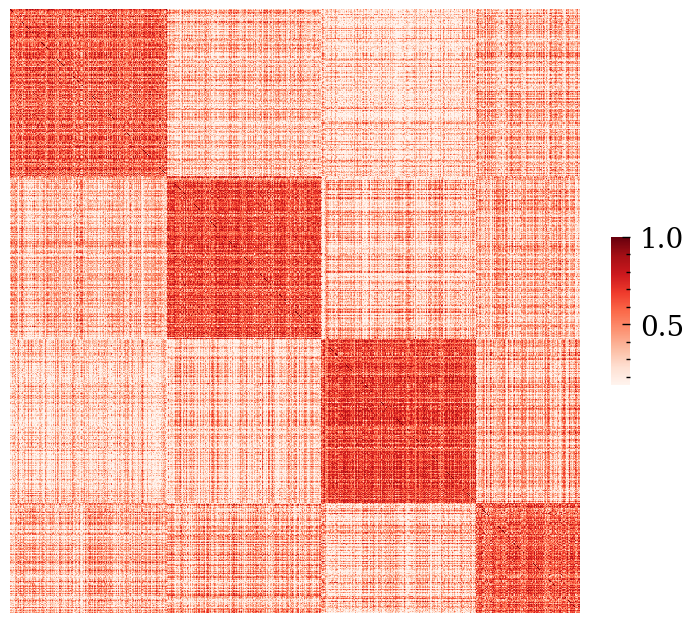

In [162]:
# print("#clusters=",str(resultall.max()-resultall.min()+1))
cluster_sorted_list=allfeas_df[allfeas_df.cluster==0].index.to_list()
for c in np.arange(1,n_clusters):
    cluster_sorted_list+=allfeas_df[allfeas_df.cluster==c].index.to_list()
showdata=all_sim_tmp[cluster_sorted_list].copy()
showdata=showdata.T[cluster_sorted_list].copy()
fig=plt.figure(figsize=(4,4),dpi=200)
fs=5
plt.subplot(111)
ax=sns.heatmap(showdata.values,
                cmap='Reds',
                xticklabels=False,
                yticklabels=False,
                vmin=0.15,
                cbar_kws={
                'orientation':'vertical',
                'fraction':0.03,
                'aspect':8,
                })
plt.show()
fig.savefig('../figs/all_cell_clustermap_basedon_morpho_feas.png',dpi=300)

In [195]:
showpie

brain_region
Others         14.00
TH             49.00
CTX           460.00

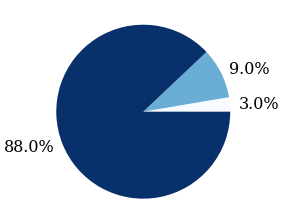

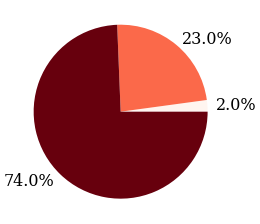

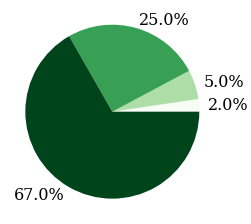

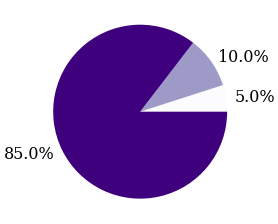

In [210]:
# cluster vs brain_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
allfeas_df.loc[:,'brain_region']= 'Others'
allfeas_df.loc[allfeas_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
allfeas_df.loc[allfeas_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
allfeas_df.loc[allfeas_df['soma_region'].isin(TH),'brain_region']= 'TH'
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('brain_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<15:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'brain_region']=cell_num[stype]
    if other_num>0:
        showpie.loc['Others','brain_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='brain_region',inplace=True)
    axes=showpie.plot(kind='pie',y='brain_region', 
                      figsize=(4,4),fontsize=16,
                      labels=[str(100*round(showpie.loc[r,'brain_region']/showpie['brain_region'].sum(),2))+'%' for r in showpie.index],
                    #   labeldistance=1.1,
                    #   autopct='%.0f%%',pctdistance=1.2,
                      legend=False,colormap=cmaps[anac])
    # plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Morpho_Cluster_btype_distribution_'+str(anac)+'.png',dpi=200)
    # break

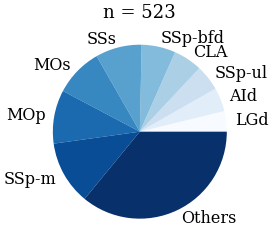

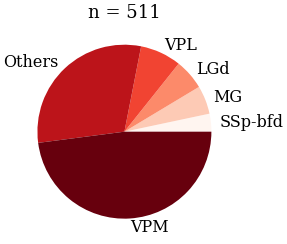

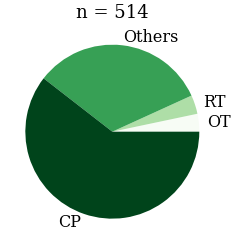

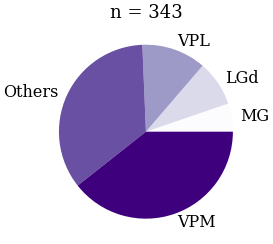

In [164]:
# cluster vs soma_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('soma_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<16:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'soma_region']=cell_num[stype]
    showpie.loc['Others','soma_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='soma_region',inplace=True)
    axes=showpie.plot(kind='pie',y='soma_region', figsize=(4,4),fontsize=16,legend=False,colormap=cmaps[anac])
    plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Morpho_Cluster_stype_distribution_'+str(anac)+'.png',dpi=200)

## clustering based on morphological features and spatial distance

In [211]:
# for the computation of dist wighted features
cbase=['black','#db1561','#2a7b7b','#392b78','#785498','#3fa540','#F6BBC6']
allfeas_raw=pd.read_csv('ana_lm_statistics_full.csv',index_col=['name'])
all_flag=True
if all_flag:
    ana_feas_data=allfeas_raw.copy()
    allfeas_df=ana_feas_data.drop(['soma_region'],axis=1).copy()
else:
    allfeas_raw.loc[:,'brain_region']= 'Other'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(CNU),'brain_region']= 'CNU'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(CTX),'brain_region']= 'CTX'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(TH),'brain_region']= 'TH'
    ana_feas_data=allfeas_raw[allfeas_raw.brain_region!='Other'].copy()
    allfeas_df=ana_feas_data.drop(['soma_region','brain_region'],axis=1).copy()
tof_path='./ana_similarity.csv'
tof_morpho_path='./ana_morpho_similarity.csv'
tof_spatial_path='./ana_spatial_similarity.csv'
if os.path.exists(tof_path):
    all_sim=pd.read_csv(tof_path,index_col=None)
    all_sim.index=all_sim.keys()
else:
    if os.path.exists(tof_morpho_path):
        cosine_sim_all=pd.read_csv(tof_morpho_path,index_col=None)
        cosine_sim_all.index=cosine_sim_all.keys()
    else:
        allfeas_s=StandardScaler().fit_transform(allfeas_df.values)
        allfeas_df_s=pd.DataFrame(allfeas_s,columns=allfeas_df.keys(),index=allfeas_df.index)
        cosine_sim_all=cosine_similarity(allfeas_df_s)
        cosine_sim_all.to_csv(tof_morpho_path,index=False)
    #2 spatial dist
    if os.path.exists(tof_spatial_path):
        spatial_sim_all=pd.read_csv(tof_spatial_path,index_col=None)
        spatial_sim_all.index=spatial_sim_all.keys()
    else:
        spatial_sim_all=spatial_dist(allfeas_df.index.to_list(),soma_dir='../data/reg_ccf_s20')
        spatial_sim_all.to_csv(tof_spatial_path,index=False)
    all_sim=cosine_sim_all*spatial_sim_all
    all_sim.to_csv(tof_path,index=False)
for cell in all_sim.index:
    if all_sim.loc[cell,cell] !=1:
        # print(cell,all_sim.loc[cell,cell])
        all_sim.loc[cell,cell]=1.0
all_sim_tmp=all_sim.replace(np.nan,0)
# allfeas_df['brain_region']=allfeas_raw['brain_region']
allfeas_df['soma_region']=allfeas_raw['soma_region']
n_clusters=4
clustering = SpectralClustering(n_clusters=n_clusters,affinity='precomputed',random_state=0).fit(all_sim_tmp)
allfeas_df['cluster']=clustering.labels_

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [ ]:
cost = []#初始化损失（距离）值
for i in range(2,8):#尝试不同的K值
    clustering = SpectralClustering(n_clusters=i,affinity='precomputed',random_state=0).fit(all_sim_tmp)
    sc_score = silhouette_score(1-all_sim_tmp, clustering.labels_, metric="precomputed")
    cost.append(sc_score)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(2,8),cost)
# plt.title('轮廓系数')
plt.ylabel('silhouette score')
plt.xlabel('#clusters')
plt.show()
fig.savefig('../figs/silhouette_score.png')

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



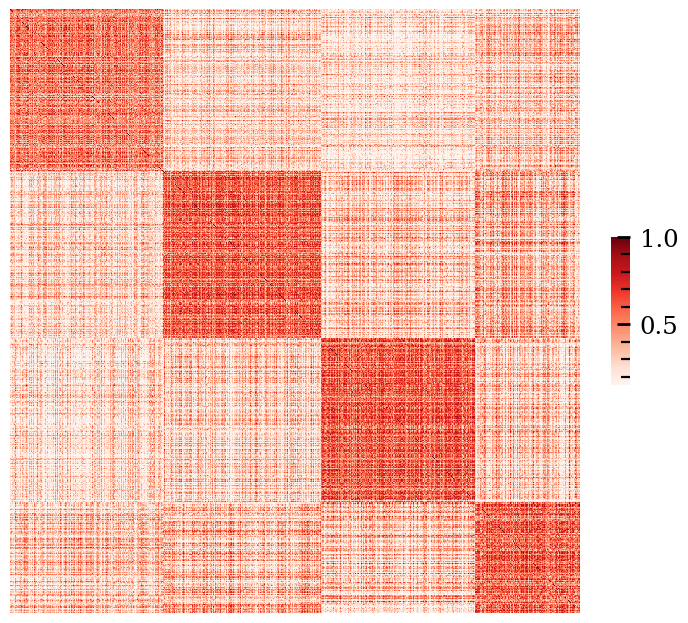

In [1413]:
# print("#clusters=",str(resultall.max()-resultall.min()+1))
cluster_sorted_list=allfeas_df[allfeas_df.cluster==0].index.to_list()
for c in np.arange(1,n_clusters):
    cluster_sorted_list+=allfeas_df[allfeas_df.cluster==c].index.to_list()
showdata=all_sim_tmp[cluster_sorted_list].copy()
showdata=showdata.T[cluster_sorted_list].copy()
fig=plt.figure(figsize=(4,4),dpi=200)
fs=5
plt.subplot(111)
ax=sns.heatmap(showdata.values,
                cmap='Reds',
                xticklabels=False,
                yticklabels=False,
                vmin=0.15,
                cbar_kws={
                'orientation':'vertical',
                'fraction':0.03,
                'aspect':8,
                })
plt.show()
fig.savefig('../figs/all_cell_clustermap.png',dpi=300)

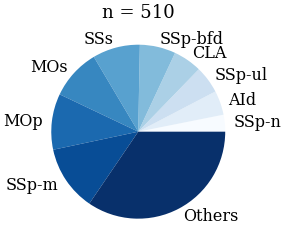

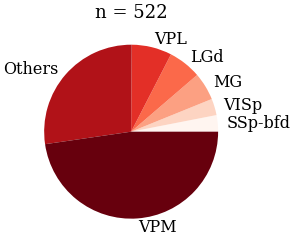

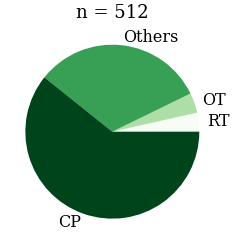

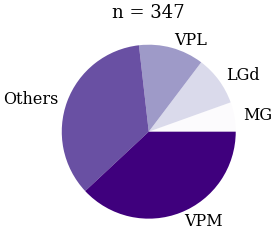

In [1669]:
# cluster vs soma_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('soma_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<16:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'soma_region']=cell_num[stype]
    showpie.loc['Others','soma_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='soma_region',inplace=True)
    axes=showpie.plot(kind='pie',y='soma_region', figsize=(4,4),fontsize=16,legend=False,colormap=cmaps[anac])
    plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Cluster_stype_distribution_'+str(anac)+'.png',dpi=200)

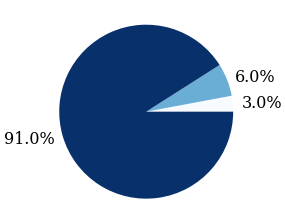

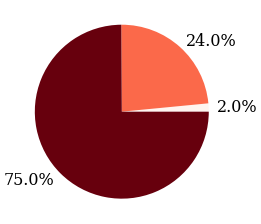

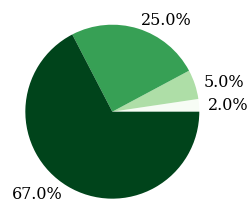

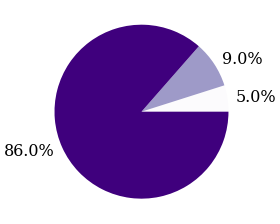

In [213]:
# cluster vs brain_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
allfeas_df.loc[:,'brain_region']= 'Others'
allfeas_df.loc[allfeas_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
allfeas_df.loc[allfeas_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
allfeas_df.loc[allfeas_df['soma_region'].isin(TH),'brain_region']= 'TH'
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('brain_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<15:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'brain_region']=cell_num[stype]
    if other_num>0:
        showpie.loc['Others','brain_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='brain_region',inplace=True)
    axes=showpie.plot(kind='pie',y='brain_region', 
                      figsize=(4,4),fontsize=16,
                      labels=[str(100*round(showpie.loc[r,'brain_region']/showpie['brain_region'].sum(),2))+'%' for r in showpie.index],
                      legend=False,colormap=cmaps[anac])
    # plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Cluster_btype_distribution_'+str(anac)+'.png',dpi=200)
    # break

In [165]:
inva_feas=[ 'asymmetry_min','asymmetry_max',  
            'br_length_min', 'br_order_min',
            'br_contraction_min','br_contraction_max',
            'bif_PathDist2soma_min','bif_EucDist2soma_min',
            'ampl_local_min','ampl_remote_min','tilt_local_min','tilt_remote_min']

gfdf_raw=allfeas_df.copy()
gfdf_raw.drop(inva_feas,axis=1,inplace=True)
gfdf_raw.dropna(inplace=True)
gfdf=gfdf_raw.copy()
# fea_names=gfdf.drop(['cluster','soma_region'],axis=1).keys().to_list()
# all_fea_s=StandardScaler().fit_transform(gfdf.drop(['cluster','soma_region'],axis=1).values)
fea_names=gfdf.drop(['cluster','soma_region','brain_region'],axis=1).keys().to_list()
all_fea_s=StandardScaler().fit_transform(gfdf.drop(['cluster','soma_region','brain_region'],axis=1).values)
standard_feas=pd.DataFrame(all_fea_s,columns=fea_names,index=gfdf.index)

# supplementary data
clustering based on morphological features

(1446, 35)


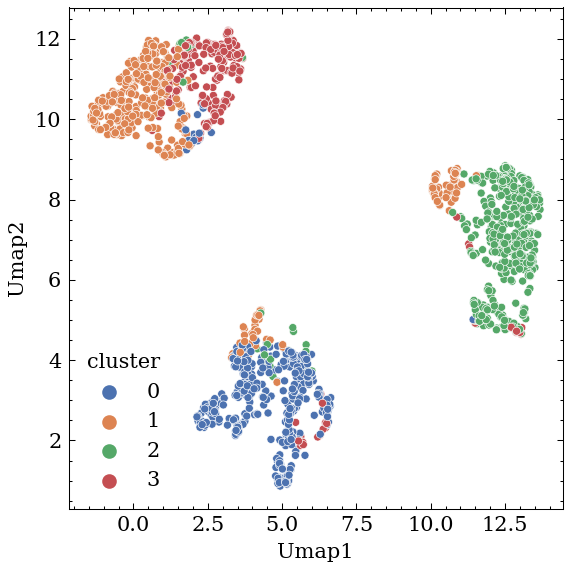

In [11]:
# fea_names=gfdf.drop(['cluster','soma_region'],axis=1).keys().to_list()
ana_data=gfdf[gfdf.soma_region.isin(ana_regions)].copy()
data_s=StandardScaler().fit_transform(ana_data.drop(['cluster','soma_region'],axis=1).values)
print(data_s.shape)
embedding = umap.UMAP(n_neighbors=15,min_dist=0.1,random_state=3).fit_transform(data_s)
ana_data['umap1']=embedding[:,0]
ana_data['umap2']=embedding[:,1]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.scatterplot(data=ana_data,x='umap1',y='umap2',s=15,palette="deep")
# plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
# plt.title('')
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.tight_layout()
plt.show()

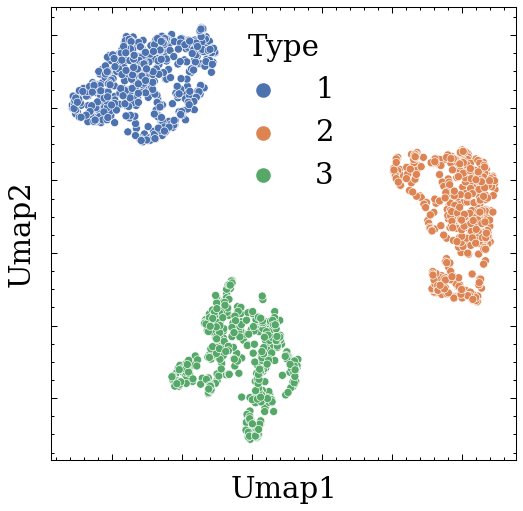

In [20]:
#Kmeans-clustering
kclusters=3
kmeansmodel = KMeans(n_clusters=kclusters,init='k-means++',random_state=3)
kmeansmodel.fit(embedding)
centers = kmeansmodel.cluster_centers_
ana_data['kmeans']=(kmeansmodel.labels_+1)
# axon_motif['region']=axon_motif_labels['motif_region']
# sc_score = silhouette_score(embedding, kmeansmodel.labels_, metric="euclidean")
# print("silhouette coefficient=%0.03f" % (sc_score))
fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
# colors = np.array(['red','green','blue','yellow','pink'])
ax=sns.scatterplot(data=ana_data,x='umap1',y='umap2',hue='kmeans',s=15,palette="deep")
# plt.scatter(centers[:, 0], centers[:, 1], s = 10,color='black')
# plt.scatter(embedding[:, 0], embedding[:, 1], c = colors[axon_motif['Kmeans-cluster']-1], s = 0.1)
ax = plt.gca()
plt.legend(loc='upper center',title='Type',fontsize=14,title_fontsize=14)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.xlabel('Umap1',fontsize=14)
plt.ylabel('Umap2',fontsize=14)
# plt.title('Axonal motif (level <4)')
plt.show()
fig.savefig('../figs/Keans_clustering_morphological_feas.png',dpi=300)

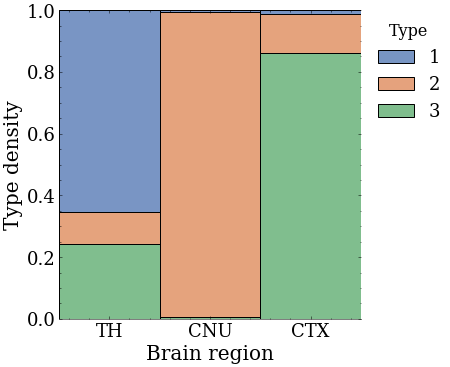

In [26]:
# ana_data
ana_data.loc[:,'brain_region']= 'Other'
ana_data.loc[ana_data['soma_region'].isin(CNU),'brain_region']= 'CNU'
ana_data.loc[ana_data['soma_region'].isin(CTX),'brain_region']= 'CTX'
ana_data.loc[ana_data['soma_region'].isin(TH),'brain_region']= 'TH'
g=sns.displot(x='brain_region',hue='kmeans',data=ana_data,palette='deep',
            multiple="fill",common_norm=False,
            legend=True)
# sns.displot(penguins, x="flipper_length_mm", hue="species", stat="density", common_norm=False)
sns.move_legend(g, "upper left",bbox_to_anchor=(.85, .97),fontsize=18,title="Type",title_fontsize=16)
# g.add_legend([1,2,3,4])
g.set_xticklabels(fontsize=18)
g.set_yticklabels(fontsize=18)
g.set_xlabels('Brain region',fontsize=20)
g.set_ylabels('Type density',fontsize=20)
g.savefig('../figs/type_ratio_in_clustering_results.png',dpi=300)

# main

In [166]:
standard_feas['cluster']=gfdf['cluster']
standard_feas.dropna(inplace=True)

In [1541]:
# for the collection of soma coord
##x,y,z,radius,shape,name,comment, color_r,color_g,color_b
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

soma_dir='../data/reg_ccf_s20'
# scolors=['95d0fc','06c2ac','ff796c','9a0eea']
sco=['16499D','E71F19','36AE37','7D4195']
for c1 in np.arange(n_clusters):
    for c2 in np.arange(n_clusters):
        if c1 >= c2:
            continue
        soma_markers=pd.DataFrame()
        for c in ([c1,c2]):
            cdata=gfdf[gfdf.cluster==c].copy()
            sc=sco[c]
            rgb=hex_to_rgb(sc)
            for cell in cdata.index:
                rpath=os.path.join(soma_dir,cell+'.swc')
                if cdata.loc[cell,'soma_region'] == 'error':
                    continue
                if os.path.join(rpath):
                    soma=get_soma(rpath)
                    soma_markers.loc[cell,'##x']=int(soma['x']/25+20)
                    soma_markers.loc[cell,'y']=int(soma['y']/25)
                    soma_markers.loc[cell,'z']=int(soma['z']/25)
                    soma_markers.loc[cell,'radius']=0
                    soma_markers.loc[cell,'shape']=1
                    soma_markers.loc[cell,'name']='C'+str(cdata.loc[cell,'cluster']+1)
                    soma_markers.loc[cell,'comment']='soma'
                    soma_markers.loc[cell,'color_r']=int(rgb[0])
                    soma_markers.loc[cell,'color_g']=int(rgb[1])
                    soma_markers.loc[cell,'color_b']=int(rgb[2])
        soma_markers.to_csv('../data/soma_'+str(c1)+'_vs_'+str(c2)+'.marker',index=False,float_format='%.0f')
# soma_markers.index.name='##'
# soma_markers.to_csv('../data/allsoma.marker',index=False,float_format='%.0f')

In [ ]:
# soma coord distribution
for c1 in np.arange(n_clusters):
    for c2 in np.arange(n_clusters):
        if c1>=c2:
            continue
        d3d_types(indf=gfdf,regions=[c1,c2],
                colors=['#ff796c','#75bbfd'],
                dims=['somax','somay','somaz'],
                labels=['Soma X','Soma Y','Soma Z'],
                figpath='../figs/Soma_cluster_'+str(c1)+'_vs_'+str(c2)+'.png',
                alpha=0.8,fs=14)

In [182]:
gfdf

stems  branches  overall_width  overall_height  \
name                                                                        
18454_01067                10.00    610.00       3,379.73        1,656.77   
191801_4228_x15043_y11097   5.00    295.00         955.38        1,401.20   
18457_00127                 6.00    520.00       3,013.65        3,885.52   
17302_00015                 7.00    229.00       1,589.53        1,548.77   
18465_00005                 8.00    620.00       4,266.65        2,381.38   
...                          ...       ...            ...             ...   
18458_00086                 5.00    487.00       2,271.50        3,197.18   
18455_5517_x15391_y12702    6.00    726.00       3,686.52        2,654.80   
18454_00141                 9.00    637.00       2,896.52        1,261.20   
17302_00062                 6.00    168.00       1,192.42        1,856.95   
18869_4883_x18883_y4120     7.00    637.00         543.08          976.55   

                           overall_depth    overall_volume  total_length  \
name                                                                       
18454_01067                     2,764.05 15,477,100,000.00     53,408.90   
191801_4228_x15043_y11097         533.70    714,449,000.00     16,409.30   
18457_00127                     4,059.90 47,539,900,000.00     64,621.40   
17302_00015                     1,210.67  2,980,460,000.00     27,766.10   
18465_00005                     1,798.78 18,276,400,000.00     29,455.70   
...                                  ...               ...           ...   
18458_00086                     1,798.75 13,063,200,000.00     52,269.10   
18455_5517_x15391_y12702        2,807.85 27,480,400,000.00     84,242.80   
18454_00141                     3,100.25 11,325,500,000.00     53,126.40   
17302_00062                     1,150.10  2,546,640,000.00     13,833.90   
18869_4883_x18883_y4120           447.32    237,234,000.00     29,968.20   

                           br_length_mean  br_length_std  br_length_max  ...  \
name                                                                     ...   
18454_01067                         87.56         146.18       2,871.46  ...   
191801_4228_x15043_y11097           55.62          62.33         537.28  ...   
18457_00127                        124.27         258.37       3,412.49  ...   
17302_00015                        121.25         127.86         626.54  ...   
18465_00005                         47.51         107.91       2,240.05  ...   
...                                   ...            ...            ...  ...   
18458_00086                        107.33         156.88       1,591.01  ...   
18455_5517_x15391_y12702           116.04         164.69       1,974.91  ...   
18454_00141                         83.40         108.14       1,289.61  ...   
17302_00062                         82.34         109.13         531.46  ...   
18869_4883_x18883_y4120             47.05          42.41         264.20  ...   

                           ampl_remote_max  tilt_local_mean  tilt_local_std  \
name                                                                          
18454_01067                         174.61           111.73           31.32   
191801_4228_x15043_y11097           171.88           106.36           38.97   
18457_00127                         176.35           110.35           31.52   
17302_00015                         174.88           114.58           29.59   
18465_00005                         162.87           104.21           32.01   
...                                    ...              ...             ...   
18458_00086                         159.02           117.91           29.37   
18455_5517_x15391_y12702            172.00           115.90           28.72   
18454_00141                         162.28           113.26           33.15   
17302_00062                         154.29           113.55           26.19   
18869_4883_x18883_y4120             170.49     

In [183]:
gfdf_with_soma=gfdf.drop(['soma_region','brain_region'],axis=1).copy()
import random
# for cell in gfdf_with_soma.index:
#     rpath=os.path.join(soma_dir,cell+'.swc')
#     # if gfdf_with_soma.loc[cell,'soma_region'] == 'error':
#     #     continue
#     if not os.path.exists(rpath):
#         continue
#     soma=get_soma(rpath)
#     gfdf_with_soma.loc[cell,'x']=int(soma['x'])
#     gfdf_with_soma.loc[cell,'y']=int(soma['y'])
#     gfdf_with_soma.loc[cell,'z']=int(soma['z'])
showdata_for_clusters=[]
for anac in np.arange(n_clusters):
    gfdf_with_soma_cluster=gfdf_with_soma[gfdf_with_soma.cluster==anac].copy()
    gfdf_with_soma_cluster.drop(['cluster'],axis=1,inplace=True)
    typical_stype_fea=gfdf_with_soma_cluster.median()
    min_fea_dist=1000000000000000000
    typical_cell=gfdf_with_soma_cluster.index[0]
    for cell in gfdf_with_soma_cluster.index:
        this_cell_fea=gfdf_with_soma_cluster.loc[cell,:].copy()
        fea_dist=(this_cell_fea-typical_stype_fea).abs().sum()
        # print(fea_dist)
        if fea_dist < min_fea_dist and cell != '18869_4883_x18883_y4120':
            typical_cell=cell
        # break
    showdata_for_cluster=[typical_cell]
    clist=random.choices(gfdf_with_soma_cluster.index.to_list(),k=3)
    showdata_for_cluster+=clist
    showdata_for_clusters.append(showdata_for_cluster)

In [184]:
showdata_for_clusters

[['18868_4192_x10967_y7007',
  '17781_4874_x11466_y11924',
  '182724_3848_x8903_y23965',
  '191812_3762_x9097_y24261'],
 ['18454_00141', '18457_00088', '18464_00048', '18454_00129'],
 ['17302_00062', '17302_00031', '17302_00059', '18454_00015'],
 ['18455_5517_x15391_y12702', '18458_00562', '18465_00347', '17545_00162']]

In [1648]:
def readswc(file,headrow=2):
    header=['n','type','x','y','z','radius','parent']
    swc=pd.read_csv(file,sep=' ',header=None,skiprows=3)
    swc.columns=header
    swc.set_index(['n'],drop=True,inplace=True)
    return swc
def saveswc(swc,tofile,scale=1,retype=None,xshift=0,flip=False):
    header=['##n','type','x','y','z','radius','parent']
    if retype is not None:
        swc['type']=retype
    if scale != 1 and scale >0:
        swc['x']/=scale
        swc['y']/=scale
        swc['z']/=scale
        if xshift:
            swc['x']+=xshift
        soma=swc[swc.parent<0].copy()
        soma=soma.iloc[0]
        sz=soma['z']
        if flip and sz > nmt.annotation.size['z']/2:
            # print('flip')
            swc['z']= nmt.annotation.size['z'] - swc['z']
    swc.reset_index(inplace=True)
    swc.to_csv(tofile,sep=' ',index=0,header=header)
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def swc_plot(file=None,inswc=None,direction='XY',title=None,linewidth=2,shift=True,xlim=None,ylim=None,
            fontsize=12,xylabel=True,alpha=0.8,no_boundary=False,no_axis=False):
    basic_width=5
    fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width))
    colors=['white','black','red','blue','magenta','yellow']
    if inswc is not None:
        swc=inswc.copy()
    else:
        if file is None:
            print('Error: input none')
            return False
        swc=nmt.swc.neuron(file).swc
    if shift:
        swc.loc[:,'x']-=swc.loc[:,'x'].min()
        swc.loc[:,'y']-=swc.loc[:,'y'].min()
        swc.loc[:,'z']-=swc.loc[:,'z'].min()
    swc_brs=swc2branches(swc)
    for br in swc_brs:
        br_color=colors[int(swc.loc[br[0],'type'])]
        br_coords=swc.loc[br,['x','y','z']].copy()
        Xe=br_coords['x'].to_list()
        Ye=br_coords['y'].to_list()
        Ze=br_coords['z'].to_list()
        if direction=='YZ':
            ax.plot(Ye, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
            xlabel_text='Y'
            ylabel_text='Z'
        elif direction=='XZ':
            ax.plot(Xe, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
            xlabel_text='X'
            ylabel_text='Z'
        else:
            ax.plot(Xe, Ye, c=br_color,linewidth=linewidth,alpha=alpha)
            xlabel_text='X'
            ylabel_text='Y'
    if xylabel:
        ax.set_xlabel(xlabel_text,fontsize=fontsize)
        ax.set_ylabel(ylabel_text,fontsize=fontsize)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    ax.tick_params(axis='x',labelsize=fontsize-2)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.tick_params(axis='y',labelsize=fontsize-2)
    ax.yaxis.set_major_locator(MaxNLocator(4))
    if title is not None:
        ax.set_title(title,fontsize=fontsize)
    if xlim is not None:
        ax.set_xlim(xlim) 
    if ylim is not None:
        ax.set_ylim(ylim)
    if no_boundary: 
        #隐藏边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    if no_axis:
        #隐藏坐标轴
        axes=plt.gca()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
    return fig, ax
def swcs_plot(files,direction='XY',title=None,linewidth=2,shift=True,xylim=True,scale_bar=True,
            fontsize=12,xylabel=True,alpha=0.8,axis_off=False,basic_width=4,dpi=200):
    # basic_width=4
    colors=['white','black','red','blue','magenta','yellow']
    swcs=[]
    xmax=0
    ymax=0
    zmax=0
    for file in files:
        swc=nmt.swc.neuron(file).swc
        swc.loc[:,'x']-=(swc.loc[:,'x'].min()+xmax)
        swc.loc[:,'y']-=(swc.loc[:,'y'].min()+ymax)
        swc.loc[:,'z']-=(swc.loc[:,'z'].min()+zmax)
        # if xmax < swc.loc[:,'x'].max():
        xmax = swc.loc[:,'x'].max()
        # if ymax < swc.loc[:,'y'].max():
        ymax = swc.loc[:,'y'].max()
        # if zmax < swc.loc[:,'z'].max():
        zmax = swc.loc[:,'z'].max()
        swcs.append(swc)

    fig, axs = plt.subplots(ncols=len(swcs), 
                            figsize=(basic_width*len(swcs),basic_width),
                            sharex=True,sharey=True,dpi=200)
    for i,swc in enumerate(swcs):
        ax=axs[i]
        swc_brs=swc2branches(swc)
        for br in swc_brs:
            br_color=colors[int(swc.loc[br[0],'type'])]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='Y'
                ylabel_text='Z'
                # xlim=[0,ymax]
                # ylim=[0,zmax]
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Z'
                # xlim=[0,xmax]
                # ylim=[0,zmax]
            elif direction=='ZX':
                ax.plot(Ze,Xe, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='Z'
                ylabel_text='X'
                # xlim=[0,zmax]
                # ylim=[0,xmax]
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Y'
                # xlim=[0,xmax]
                # ylim=[0,ymax]
        # if xylim:
        #     ax.set_xlim(xlim) 
        #     ax.set_ylim(ylim)
        if axis_off:
            #隐藏坐标轴
            ax.set_axis_off()
        else:
            if xylabel:
                ax.set_xlabel(xlabel_text,fontsize=fontsize)
                ax.set_ylabel(ylabel_text,fontsize=fontsize)
            else:
                ax.set_xlabel('')
                ax.set_ylabel('')
            ax.tick_params(axis='x',labelsize=fontsize-2)
            ax.xaxis.set_major_locator(MaxNLocator(4))
            ax.tick_params(axis='y',labelsize=fontsize-2)
            ax.yaxis.set_major_locator(MaxNLocator(4))
        if title is not None:
            ax.set_title(title,fontsize=fontsize)
    if scale_bar:
        ax=axs[0]
        x_len=100
        scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
        xshift=ax.get_xlim()[1]*0.99
        sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/((dpi*basic_width)/x_len)
        sbar_endx=ax.get_xlim()[1]-xshift
        sbar_y=ax.get_ylim()[1]*0.8
        ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=4)
        ax.text(sbar_startx,sbar_y+10,str(scale_len)+"um",fontsize=20)
    plt.tight_layout()
    return fig, axs

In [ ]:
def stype_plot(files,fig=None,ax=None,direction='XY',title=None,flip_z=True,scale_bar=False,
                linewidth=2,shift=True,fontsize=12,colorful=True,alpha=0.1,axis_off=False,
                xylabel=True,markersize=14,dpi=200):
    basic_width=5
    colors=['black','black','black','black','black','black']
    if colorful:
        colors=['white','black','red','blue','magenta','yellow']
        # colors=['white','black','red','blue','green','yellow']
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1, figsize=(basic_width,basic_width),dpi=dpi)
    swcs=[]
    for file in files:
        swc=nmt.swc.neuron(file).swc
        rid=get_rid(swc)
        zshift=swc.loc[rid,'z']
        if flip_z:
            flip_thre=nmt.annotation.size['z']*25
            if swc.loc[rid,'z']>flip_thre/2:
                swc.loc[:,'z']=flip_thre-swc.loc[:,'z']
                zshift=flip_thre-zshift
        swc.loc[:,'x']-=swc.loc[rid,'x']
        swc.loc[:,'y']-=swc.loc[rid,'y']
        swc.loc[:,'z']-=zshift
        swcs.append(swc) 
    ax.tick_params(labelsize=fontsize)
    for i,swc in enumerate(swcs):
        
        # swc=nmt.swc.neuron(file).swc
        swc_brs=swc2branches(swc)
        for br in swc_brs:
            cindex=int(swc.loc[br[0],'type'])
            if cindex >= len(colors):
                cindex=0
            br_color=colors[cindex]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='Y'
                ylabel_text='Z'
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Z'
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Y'
    if scale_bar:
        x_len=75
        scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))
        xshift=ax.get_xlim()[1]*0.99
        sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/((dpi*basic_width)/x_len)
        sbar_endx=ax.get_xlim()[1]-xshift
        sbar_y=ax.get_ylim()[1]*0.8
        ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=4)
        ax.text(sbar_startx-ax.get_xlim()[1]*0.3,sbar_y+200,str(scale_len)+" um",fontsize=20)
        ax.text
    if xylabel:
        ax.set_xlabel(xlabel_text,fontsize=fontsize)
        ax.set_ylabel(ylabel_text,fontsize=fontsize)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    if axis_off:
        ax.set_axis_off()
    if title is not None:
        ax.set_title(title,fontsize=fontsize)
    # plt.tight_layout()
    return fig, ax

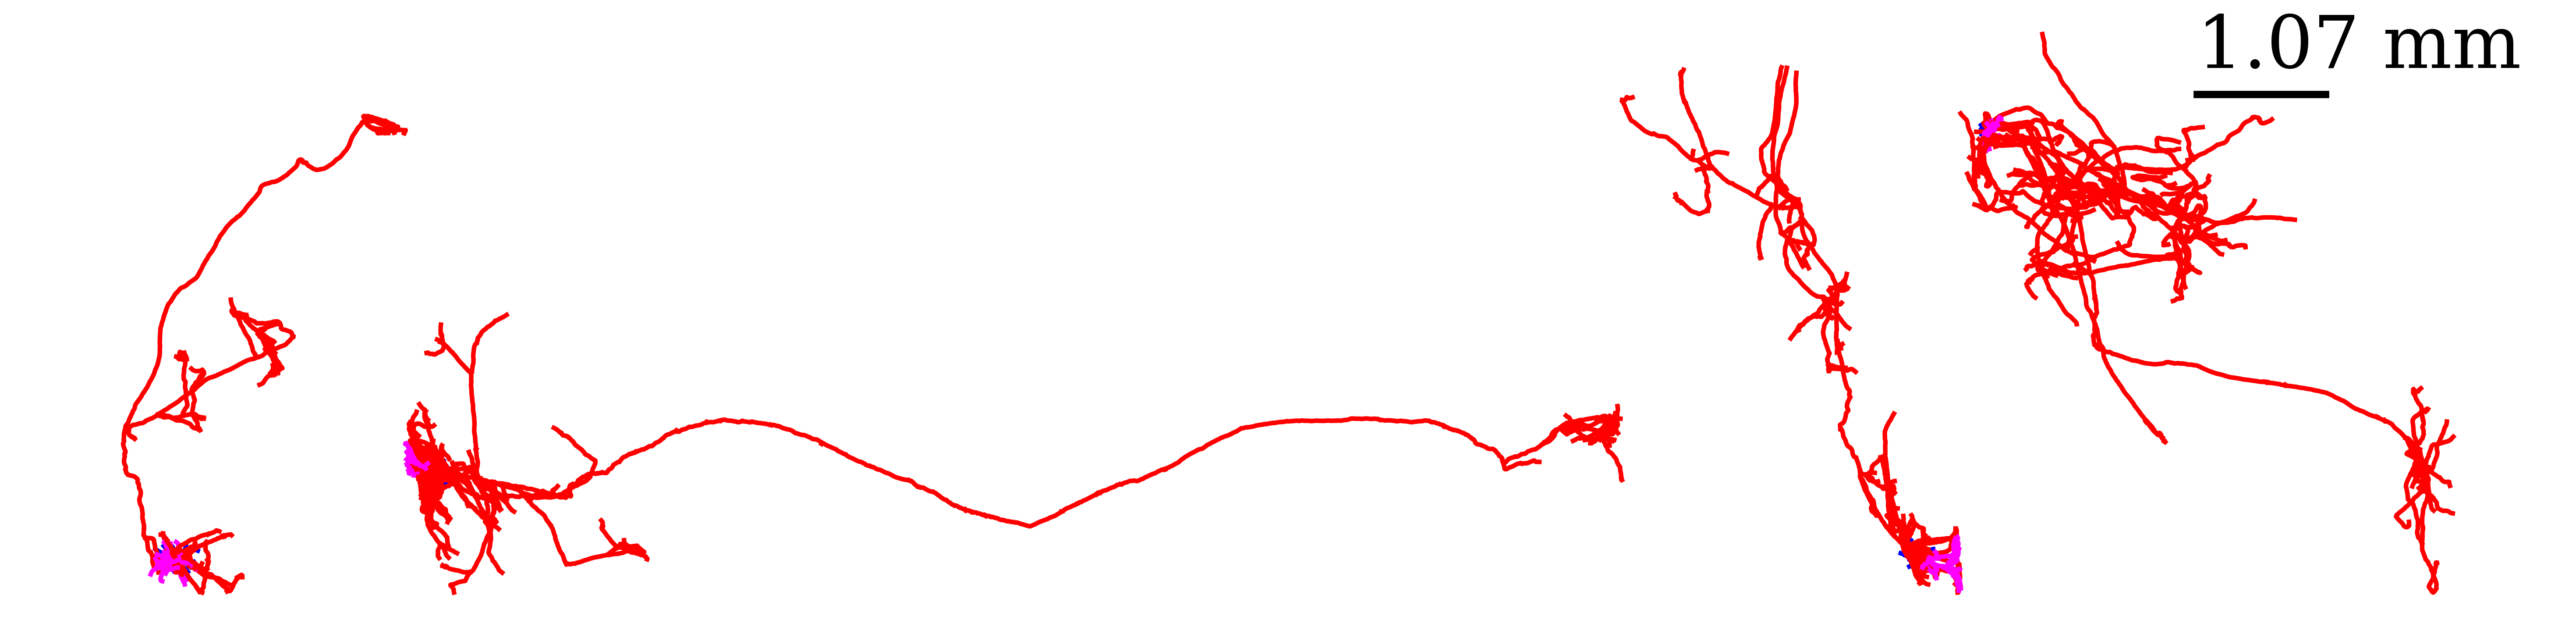

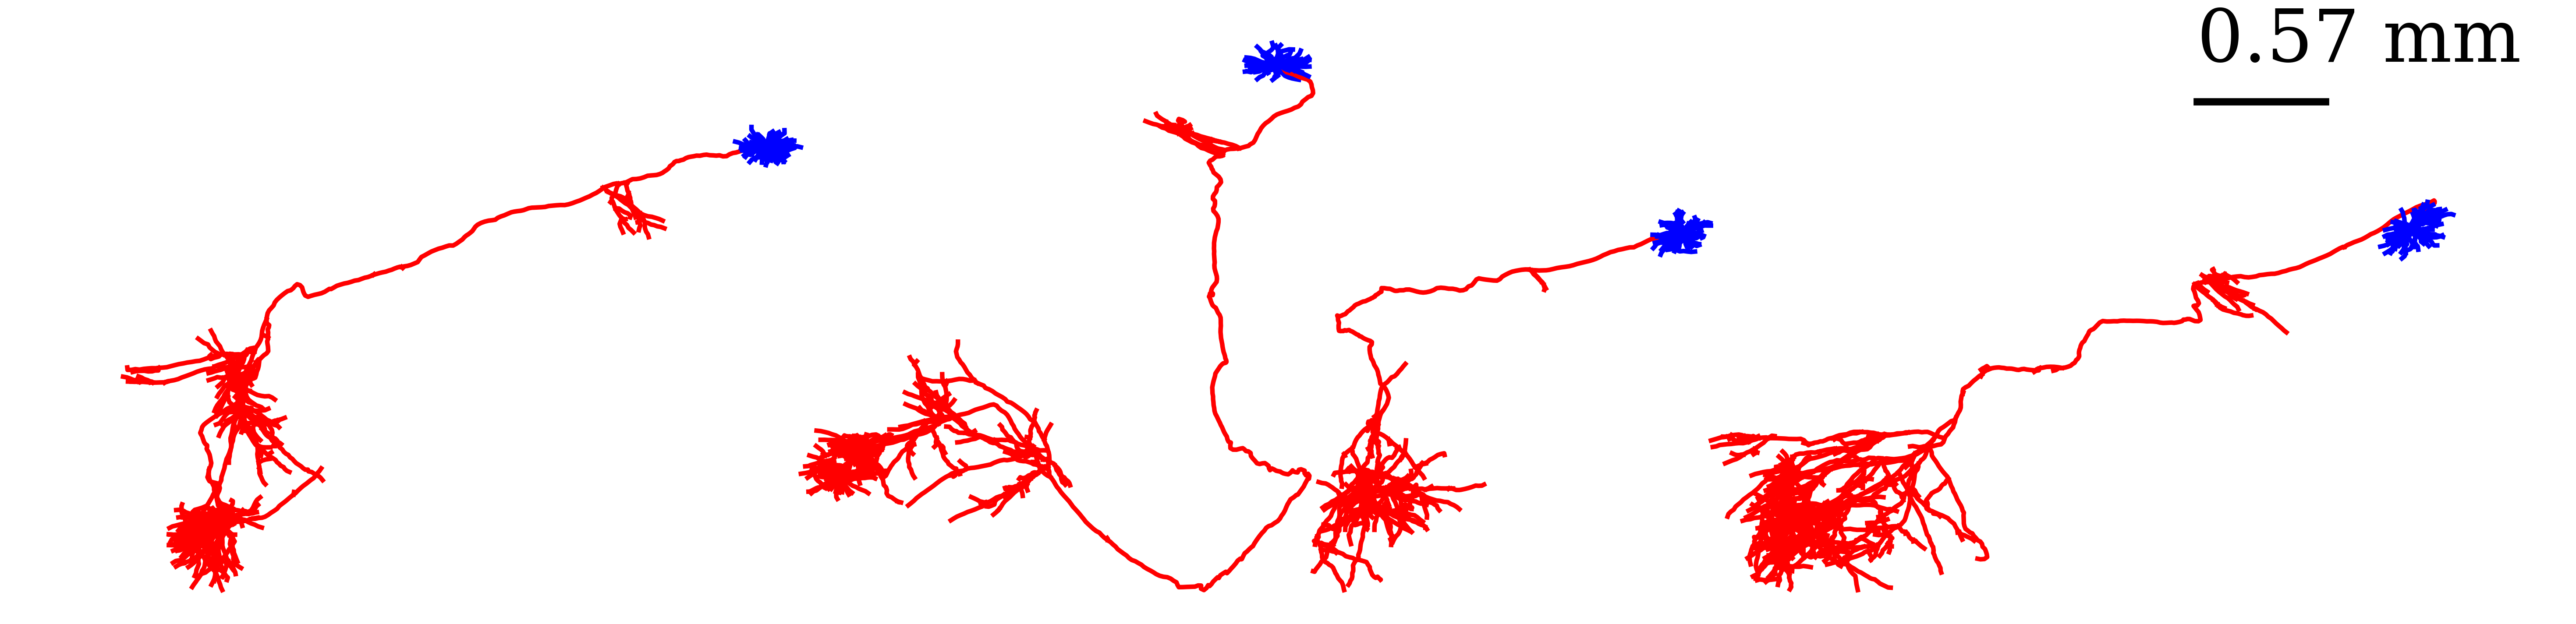

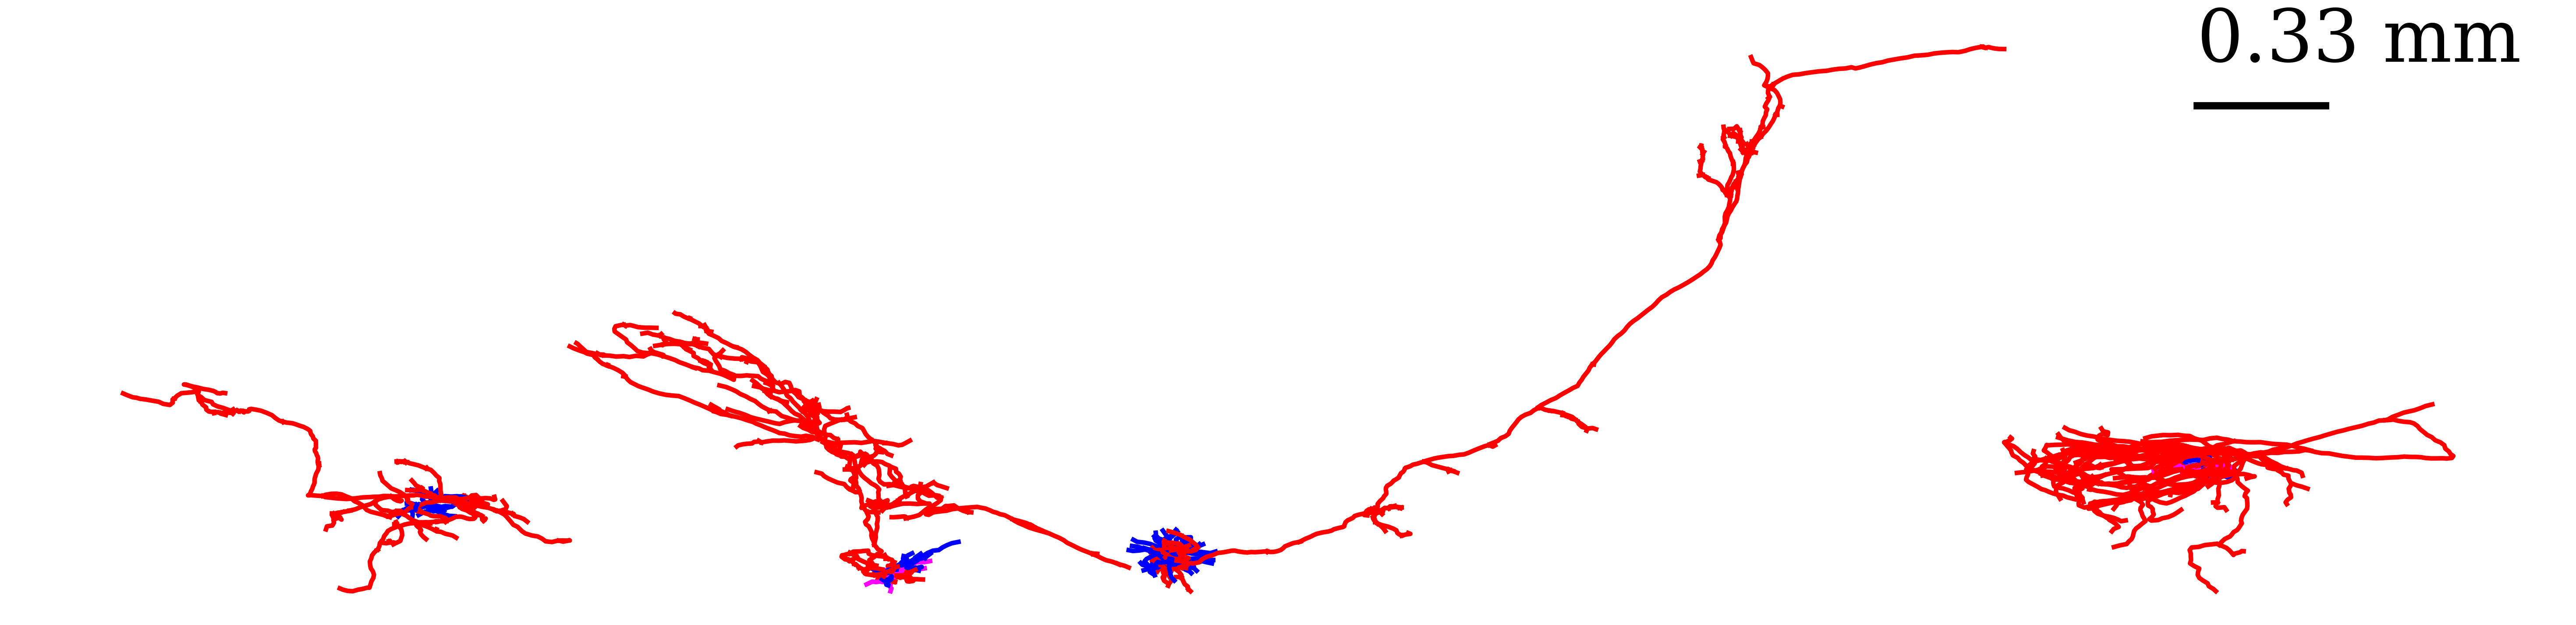

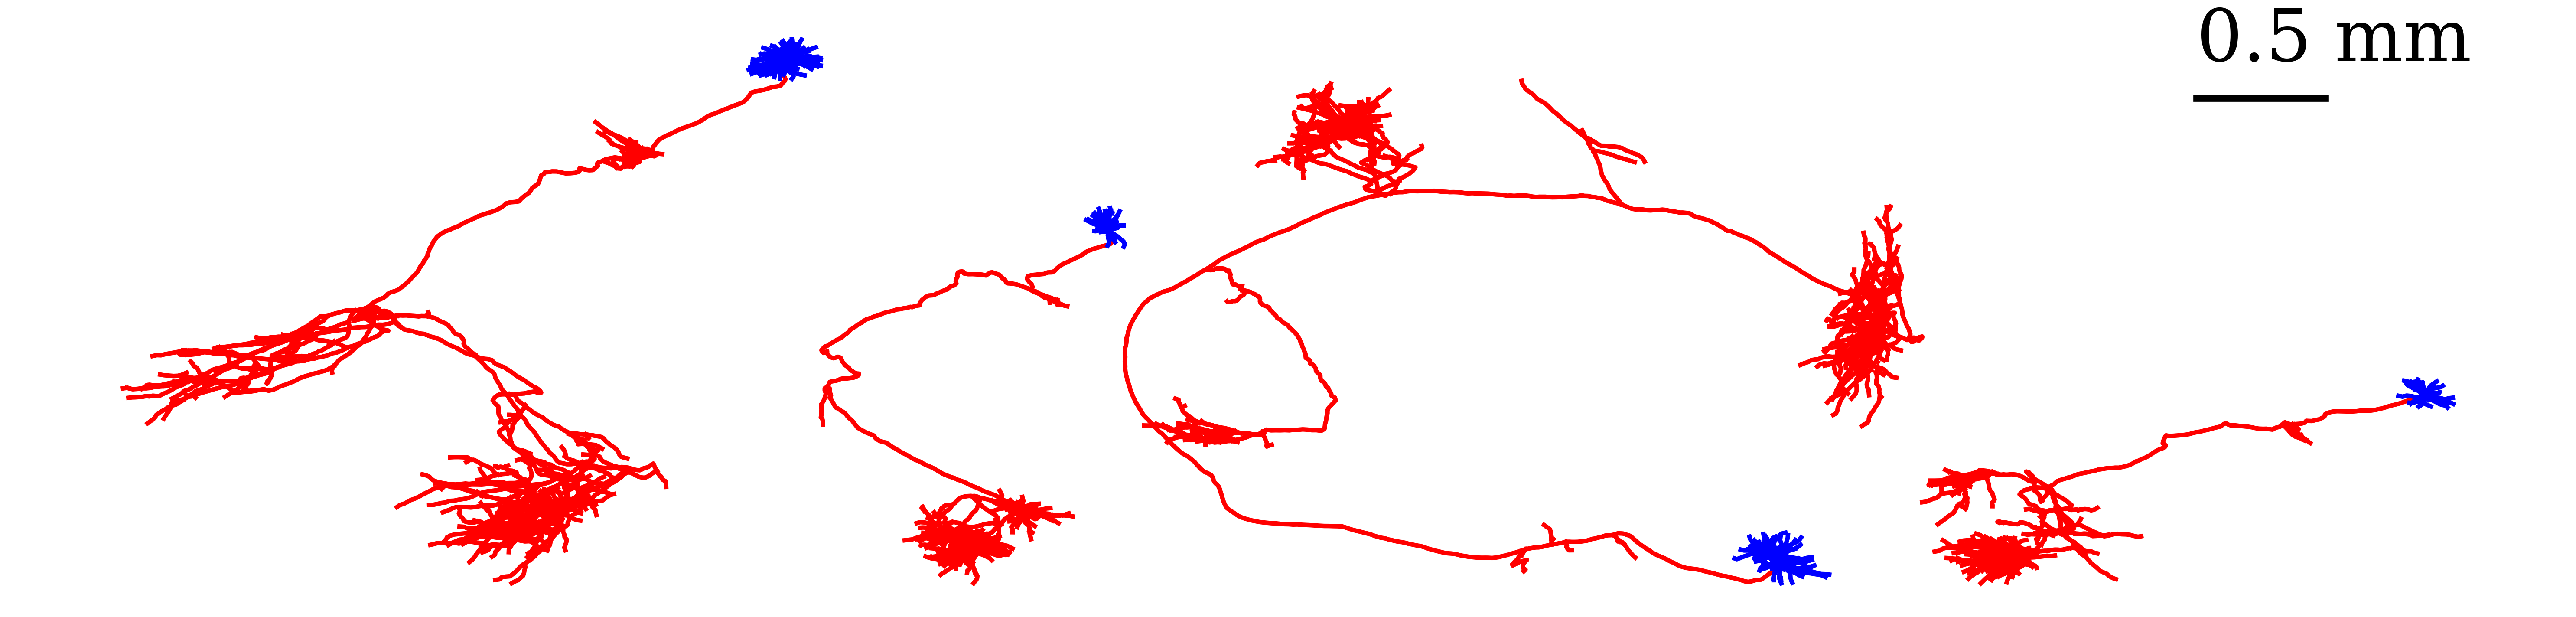

In [1665]:
def swcs_plot_in_one(files,direction='XY',title=None,linewidth=2,shift=True,xylim=True,scale_bar=True,
            fontsize=12,xylabel=True,alpha=0.8,axis_off=False,basic_width=4,dpi=200):
    # basic_width=4
    colors=['white','black','red','blue','magenta','yellow']
    swcs=[]
    xmax_shift=0
    ymax_shift=0
    zmax_shift=0
    for file in files:
        rawswc=nmt.swc.neuron(file).swc
        swc=rawswc.copy()
        swc.loc[:,'x']-=(swc.loc[:,'x'].min())
        swc.loc[:,'y']-=(swc.loc[:,'y'].min())
        swc.loc[:,'z']-=(swc.loc[:,'z'].min())
        if direction == 'XY' or direction == 'XZ':
            swc.loc[:,'x']+=(xmax_shift)
        if direction == 'YX' or direction == 'YZ':
            swc.loc[:,'y']+=(ymax_shift)
        if direction == 'ZX' or direction == 'ZY':
            swc.loc[:,'z']+=(zmax_shift)
        xmax_shift += (rawswc.loc[:,'x'].max()-rawswc.loc[:,'x'].min())
        ymax_shift += (rawswc.loc[:,'y'].max()-rawswc.loc[:,'y'].min())
        zmax_shift += (rawswc.loc[:,'z'].max()-rawswc.loc[:,'z'].min())
        # if xmax < (rawswc.loc[:,'x'].max()-rawswc.loc[:,'x'].min()):
        #     xmax = (rawswc.loc[:,'x'].max()-rawswc.loc[:,'x'].min())
        # if ymax < (rawswc.loc[:,'y'].max()-rawswc.loc[:,'y'].min()):
        #     ymax = (rawswc.loc[:,'y'].max()-rawswc.loc[:,'y'].min())
        # if zmax < (rawswc.loc[:,'z'].max()-rawswc.loc[:,'z'].min()):
        #     zmax = (rawswc.loc[:,'z'].max()-rawswc.loc[:,'z'].min())
        swcs.append(swc)
    # print('swc num=',len(swcs))
    fig, ax = plt.subplots(1,1,figsize=(basic_width*len(swcs),basic_width),dpi=300)
    for i,swc in enumerate(swcs):
        # ax=axs[i]
        swc_brs=swc2branches(swc)
        for br in swc_brs:
            br_color=colors[int(swc.loc[br[0],'type'])]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='Y'
                ylabel_text='Z'
                xlim=[0,ymax_shift]
                ylim=[0,zmax_shift]
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Z'
                xlim=[0,xmax_shift]
                ylim=[0,zmax_shift]
            elif direction=='ZX':
                ax.plot(Ze,Xe, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='Z'
                ylabel_text='X'
                xlim=[0,zmax_shift]
                ylim=[0,xmax_shift]
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth,alpha=alpha)
                xlabel_text='X'
                ylabel_text='Y'
                xlim=[0,xmax_shift]
                ylim=[0,ymax_shift]
            
    if xylim:
        ax.set_xlim(xlim) 
        ax.set_ylim(ylim)
    if axis_off:
        #隐藏坐标轴
        ax.set_axis_off()
    else:
        if xylabel:
            ax.set_xlabel(xlabel_text,fontsize=fontsize)
            ax.set_ylabel(ylabel_text,fontsize=fontsize)
        else:
            ax.set_xlabel('')
            ax.set_ylabel('')
        ax.tick_params(axis='x',labelsize=fontsize-2)
        ax.xaxis.set_major_locator(MaxNLocator(4))
        ax.tick_params(axis='y',labelsize=fontsize-2)
        ax.yaxis.set_major_locator(MaxNLocator(4))
    if title is not None:
        ax.set_title(title,fontsize=fontsize)
    if scale_bar:
        # ax=axs[0]
        x_len=50
        scale_len=math.floor(x_len*(ax.get_xlim()[1]-ax.get_xlim()[0])/(dpi*basic_width))*25
        xshift=ax.get_xlim()[1]*0.1
        sbar_startx=ax.get_xlim()[1]-xshift-(ax.get_xlim()[1]-ax.get_xlim()[0])/((dpi*basic_width)/x_len)
        sbar_endx=ax.get_xlim()[1]-xshift
        sbar_y=ax.get_ylim()[1]*0.85
        ax.plot([sbar_startx,sbar_endx],[sbar_y,sbar_y],c='black',linewidth=4)
        ax.text(sbar_startx,sbar_y+10,str(round(scale_len/1000,2))+" mm",fontsize=40)
    plt.tight_layout()
    return fig, axs
show_num=4
for c,cluster in enumerate(showdata_for_clusters):
    show_swcs=[]
    for cell in cluster:
        swcpath=os.path.join(tdir,cell+'.swc')
        show_swcs.append(swcpath)
        if show_num<=len(show_swcs):
            break
    fig,axs=swcs_plot_in_one(files=show_swcs,direction='ZX',basic_width=5,alpha=1,linewidth=2.5,axis_off=True,xylim=False)
    fig.savefig('../figs/cluster_neuron_rep_'+str(c+1)+'.png',dpi=300)
    # break

In [1581]:
for cell in gfdf.index:
    topath=os.path.join(tdir,cell+'.swc')
    frompath=os.path.join(swcdir,cell+'.swc')
    rawswc=nmt.swc.neuron(frompath).swc
    saveswc(swc=rawswc,tofile=topath,scale=25,xshift=0,flip=True)

In [186]:
todir='../data/morpho_showdata_for_clusters'
tdir='../data/reg_ccf_25um'
import shutil
if not os.path.exists(todir):
    os.mkdir(todir)
for ci,cells in enumerate(showdata_for_clusters):
    cdir=os.path.join(todir,str(ci))
    if not os.path.exists(cdir):
        os.mkdir(cdir)
    for si,cell in enumerate(cells):
        topath=os.path.join(cdir,str(si+1)+'_'+cell+'.swc')
        frompath=os.path.join(tdir,cell+'.swc')
        # rawswc=nmt.swc.neuron(frompath).swc
        # saveswc(swc=rawswc,tofile=topath,scale=25,xshift=20)
        shutil.copy(frompath,topath)

In [167]:
def mrmr_fea_all_type(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    ana_data=indata.copy()
    for i,f1 in enumerate(stype_list):
        ana_data.loc[ana_data.cluster==f1,'cluster']=(1+i)
    new_fea_list=['cluster']
    for fea in fea_names:
        new_fea_list.append(fea)
    ana_data=ana_data[new_fea_list]
    mrmrout=pymrmr.mRMR(ana_data,'MID',picked_fea)
    return mrmrout
def mrmr_fea_pairtype(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    sfeas=['mRMR'+str(x) for x in np.arange(1,picked_fea+1)]
    outkeys=['s1','s2']+sfeas
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                continue
            data_2stypes=indata[indata.cluster.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.cluster==f1,'cluster']=1
            data_2stypes.loc[data_2stypes.cluster==f2,'cluster']=2
            new_fea_list=['cluster']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            # print(len(mrmrout))
            out_tmp=[f1,f2]+mrmrout
            out_tmpdf=pd.DataFrame(out_tmp)
            outdf=pd.concat([outdf,out_tmpdf],axis=1,ignore_index=True)   
    outdata=outdf.T.copy()
    outdata.columns=outkeys
    return outdata

dataraw=standard_feas.copy()
# allbfeas=mrmr_fea_all_type(indata=dataraw,picked_fea=3)
allbfeas=mrmr_fea_pairtype(indata=dataraw,picked_fea=3)

In [147]:
allbfeas

s1 s2                   mRMR1               mRMR2                mRMR3
0  1  2    bif_EucDist2soma_max    ampl_remote_mean       overall_height
1  1  0    bif_EucDist2soma_max     tilt_remote_std  br_contraction_mean
2  1  3    bif_EucDist2soma_max        br_order_max       br_length_mean
3  2  0        tilt_remote_mean      tilt_local_std   br_contraction_std
4  2  3  bif_PathDist2soma_mean  br_contraction_std             branches
5  0  3            br_order_max     tilt_remote_std       ampl_local_max

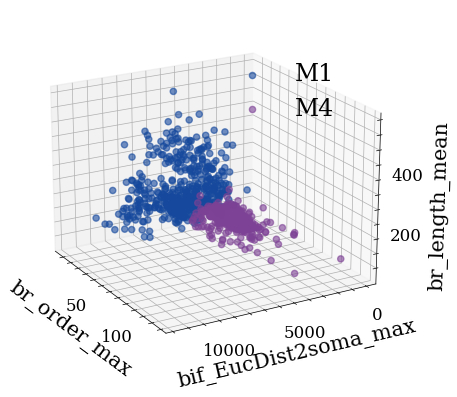

In [181]:
def d3d_types(indf,regions=['TH','CNU'],
                    colors=['blue','red'],
                    dims=['length','volume','contraction'],
                    labels=None,legend=True,
                    figpath=None,alpha=0.5,fs=12,
                    viewx=0,viewy=0):
    fig=plt.figure(figsize=(4,4),dpi=100)
    ax = fig.add_subplot(projection='3d')
    indf=indf[indf.cluster.isin(regions)].copy()
    for bi,br in enumerate(regions):
        sdata=indf[indf.cluster==br].copy()
        ax.scatter(sdata[dims[0]],sdata[dims[1]],sdata[dims[2]],c=colors[bi],
                    # label=br,
                    label='M'+str(br+1),
                    alpha=alpha,
                    # marker=MarkerStyle(marker='o',fillstyle='none'),
                    s=20*np.ones(sdata.shape[0]))
    if legend:
        plt.legend(loc='upper left',bbox_to_anchor=(0.5,0.9),title='',fontsize=fs+2)
    
    if labels is None:
        ax.set_xlabel(dims[0],fontsize=fs)
        ax.set_ylabel(dims[1],fontsize=fs)
        ax.set_zlabel(dims[2],fontsize=fs)
    else:
        ax.set_xlabel(labels[0],fontsize=fs)
        ax.set_ylabel(labels[1],fontsize=fs)
        ax.set_zlabel(labels[2],fontsize=fs)
    # First remove fill
    ax.tick_params(axis='x',labelsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='y',labelsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='z',labelsize=12)
    ax.zaxis.set_major_locator(MaxNLocator(3))
    # ax.set_xticks([])
    # ax.xaxis.set_ticklabels(fontsize=fs-1)
    # ax.xaxis.pane.fill = False
    # ax.yaxis.pane.fill = False
    # ax.zaxis.pane.fill = False

    # # Now set color to white (or whatever is"invisible")
    # ax.xaxis.pane.set_edgecolor('w')
    # ax.yaxis.pane.set_edgecolor('w')
    # ax.zaxis.pane.set_edgecolor('w')
    # # ax.grid(linestyle=':')
    # # ax.set_title('Distribution at optimal feature subspace')
    if viewx !=0 or viewy !=0:
        ax.view_init(viewx,viewy)
    #     # ax.xaxis._axinfo['juggled'] = (0,0,0)
    #     # ax.yaxis._axinfo['juggled'] = (1,1,1)
        ax.zaxis._axinfo['juggled'] = (1,2,2)
    plt.tight_layout()
    plt.show()
    if figpath is not None:
        fig.savefig(figpath,dpi=300)
    return fig,ax
for cmp_pair in allbfeas.index:
    s1=allbfeas.loc[cmp_pair,'s1']
    s2=allbfeas.loc[cmp_pair,'s2']
    cmp_feas=allbfeas.loc[cmp_pair,['mRMR1','mRMR2','mRMR3']]
scolors=['#16499D','#E71F19','#36AE37','#7D4195']
for cmp_pair in allbfeas.index:
    if cmp_pair != 2:
        continue
    s1=allbfeas.loc[cmp_pair,'s1']
    s2=allbfeas.loc[cmp_pair,'s2']
    if s2<s1:
        s2=allbfeas.loc[cmp_pair,'s1']
        s1=allbfeas.loc[cmp_pair,'s2']
    cmp_feas=allbfeas.loc[cmp_pair,['mRMR1','mRMR2','mRMR3']].to_list()
    cpcolors=[scolors[s1],scolors[s2]]
    d3d_types(indf=gfdf,regions=[s1,s2],
                colors=cpcolors,
                dims=cmp_feas,
                # labels=['','',''],
                labels=cmp_feas,
                # legend=False,
                figpath='../figs/cluster_'+str(s1)+'_vs_'+str(s2)+'.png',
                alpha=0.6,fs=15,
                viewx=20,viewy=60
                )
    # break

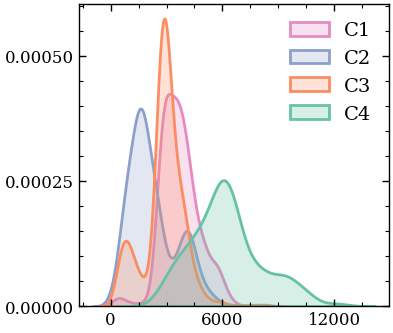

In [1510]:
fig=plt.figure(figsize=(4,4),dpi=100)
fs=14
plt.subplot(111)
ax=sns.kdeplot(data=gfdf[gfdf.cluster>=0],fill=True,
                x='bif_EucDist2soma_max',hue='cluster',
                palette='Set2',linewidth=2,common_norm=False)
ax.tick_params(axis='x',labelsize=fs-2)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.tick_params(axis='y',labelsize=fs-2)
ax.yaxis.set_major_locator(MaxNLocator(3))
# ax.set_yscale('linear')
# plt.legend(labels)
plt.legend(labels=['C'+str(c+1) for c in np.arange(n_clusters)],title='',fontsize=fs)
plt.xlabel('',fontsize=fs)
plt.ylabel('')
plt.show()
fig.savefig('../figs/bif_EucDist2soma_max_of_clusters.png',dpi=300)

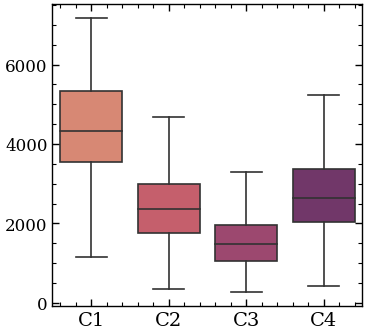

In [1504]:
fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
ax=sns.boxplot(data=allfeas_df,y='overall_height',x='cluster',
            palette='flare',showfliers=False
            )

plt.ylabel('Overall height (um)',fontsize=14)
plt.xlabel('')
plt.xticks(ticks=np.arange(n_clusters),labels=['C'+str(c+1) for c in np.arange(n_clusters)],fontsize=14)
ax.tick_params(axis='y',labelsize=12)
ax.yaxis.set_major_locator(MaxNLocator(4))
# plt.yticks(fontsize=12)
plt.ylabel('')
plt.show()
fig.savefig('../figs/overall_height_of_clusters.png',dpi=300)

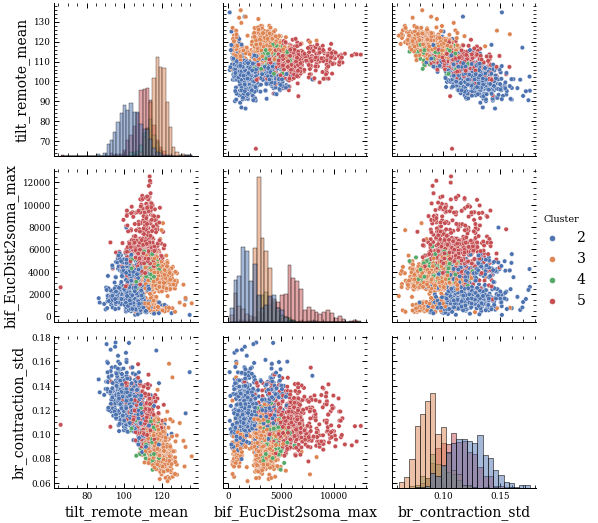

In [907]:
def pair_plot(indf,feas,brs=['CNU','TH'],figpath=None,palette='deep',fs=14):
    pair_data=indf[feas+['cluster']].copy()
    pair_data=pair_data[(pair_data.cluster.isin(brs))].copy()
    sns.set_context("paper",rc={"axes.labelsize":fs})
    g=sns.PairGrid(pair_data,hue='cluster',palette=palette)
    g.map_offdiag(sns.scatterplot,s=20)
    g.map_diag(sns.histplot)
    g.add_legend(title='Cluster',fontsize=fs)
    # g.axes.labelsize=12
    # g=sns.pairplot(data=pair_data,hue='brain_region',diag_kind=diag_kind)
    # g.tick_params(labelsize=12)
    if figpath is not None:
        spath=os.path.join(figpath,brs[0]+'_'+brs[1]+'_pair.png')
        g.savefig(spath,dpi=300)
    return g
pair_plot(gfdf,feas=allbfeas,brs=[2,3,4,5])

In [1513]:
subfeas

1               2             0               3
1               -  14,21,27,30,32  3,6,13,17,33  12,15,25,30,33
2  14,21,27,30,32               -  3,8,17,19,26   1,14,15,18,32
0    3,6,13,17,33    3,8,17,19,26             -     3,4,7,12,17
3  12,15,25,30,33   1,14,15,18,32   3,4,7,12,17               -

In [1502]:
# For all stypes in ctx
def mrmr_feag_pick(indata,picked_fea=3,stype_list = None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                if i ==j:
                    outdf.loc[f1,f2]='-'
                continue
            data_2stypes=indata[indata.cluster.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.cluster==f1,'cluster']=1
            data_2stypes.loc[data_2stypes.cluster==f2,'cluster']=2
            new_fea_list=['cluster']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            feag_index=[fea_names.index(x) for x in mrmrout]
            feag_str=''
            for mfi,mf in enumerate(sorted(feag_index)):
                fea_append=(str(mf)+',')
                if mfi == len(mrmrout) -1:
                    fea_append = str(mf)
                feag_str+=fea_append
            outdf.loc[f1,f2]=feag_str
            outdf.loc[f2,f1]=feag_str
    return outdf
data_raw=standard_feas[standard_feas.cluster>=0].copy()
# data_raw=standard_feas[standard_feas.soma_region.isin(['MOp','MOs','SSs'])].copy()
# data_raw.drop(['name','brain_region'],axis=1,inplace=True)
# data_raw.loc[data_raw.soma_region.isin(['SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n']),'soma_region']='SSp'
# subfeas=mrmr_feag_pick(indata=data_raw,picked_fea=3,stype_list=fregions)
# data_raw.loc[data_raw.soma_region.isin(TH),'soma_region']='TH_Stypes'
subfeas=mrmr_feag_pick(indata=data_raw,picked_fea=5)
# subfeas.to_numpy().reshape(1,-1).tolist()[0]
# subfeas
# most selected feature for each stype
frank_2sts=pd.DataFrame(index=subfeas.index,columns=fea_names)
for s in subfeas.index:
    for fea in fea_names:
        frank_2sts.loc[s,fea]=0
for s1 in subfeas.index:
    for s2 in subfeas.keys():
        selected_str=subfeas.loc[s1,s2]
        selected_repo=[x for x in selected_str.split(',')]
        for fi,fea in enumerate(fea_names):
            frank_2sts.loc[s1,fea]+=selected_repo.count(str(fi))
# frank_2sts
frank_2sts_h=frank_2sts.copy()
thre_times=1
for fea in frank_2sts.keys():
    if frank_2sts[fea].max() < thre_times:
        frank_2sts_h.drop([fea],axis=1,inplace=True)
frank=[frank_2sts_h[x].sum() for x in frank_2sts_h.keys()]
frank.sort()
feas=frank_2sts_h.keys().to_list()
feas_sort=[]
for x in frank:
    for f in (frank_2sts_h.keys().to_list()):
        if (frank_2sts_h[f].sum() == x) and feas.count(f):
            feas_sort.append(f)
            fi=feas.index(f)
            del feas[fi]
            break
frank_pair=frank_2sts_h[feas_sort].astype(np.int32).T
frank_pair

1  2  0  3
branches                0  1  0  1
overall_depth           0  0  1  1
total_length            1  0  1  0
br_length_mean          0  0  1  1
br_length_std           0  1  1  0
br_contraction_mean     1  0  1  0
bif_PathDist2soma_mean  0  1  0  1
bif_PathDist2soma_std   0  1  1  0
asymmetry_mean          1  1  0  0
ampl_local_max          1  0  0  1
ampl_remote_mean        0  1  1  0
ampl_remote_std         1  1  0  0
br_order_max            1  0  1  2
br_contraction_std      1  2  0  1
bif_EucDist2soma_mean   1  1  0  2
tilt_local_std          2  1  0  1
tilt_remote_mean        1  2  0  1
tilt_remote_std         2  0  1  1
overall_height          1  1  3  1
bif_EucDist2soma_max    1  1  3  1

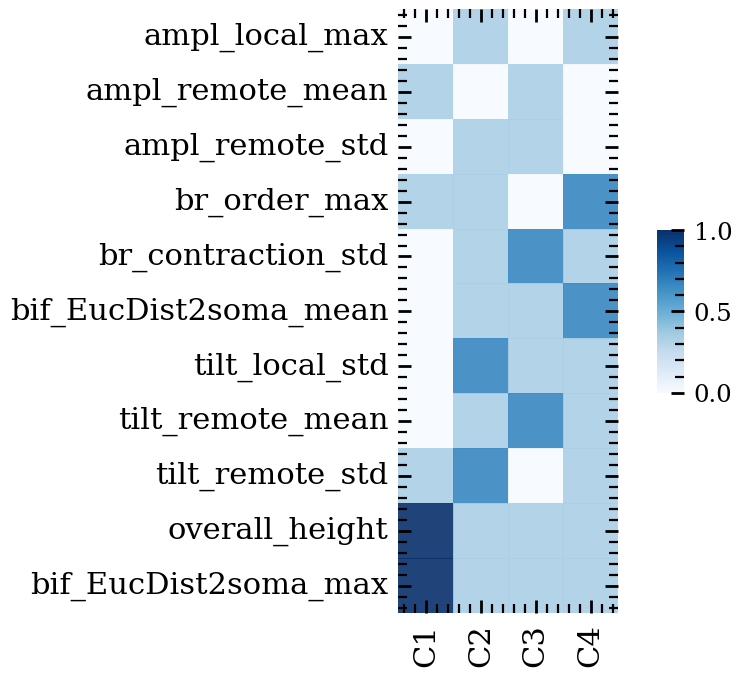

In [1512]:
newslist=np.arange(n_clusters)
frank_pair_prune=frank_pair.iloc[9:,:].copy()
frank_pair_prune=frank_pair_prune/(len(newslist)-1)
# newslist=['SSp-n','SSp-un','SSp-ll','SSp-bfd','SSp-m','SSp-ul']
fig=plt.figure(figsize=(5,4),dpi=200)
fs=11
plt.subplot(111)
ax=sns.heatmap(frank_pair_prune[newslist],cmap='Blues',
                square=True,
                annot=False,alpha=0.9,
                # annot_kws={'fontsize':10},
                # cbar_pos=(0.9,0.05,0.02,0.15),
                cbar_kws={
                'orientation':'vertical',
                'fraction':0.035,
                # 'label':'Hit rate',
                'aspect':6,
                })
plt.xticks(ticks=np.arange(len(newslist))+0.5,fontsize=fs,labels=['C'+str(c+1) for c in newslist],rotation=90)
plt.yticks(fontsize=fs)
plt.show()
fig.savefig('../figs/all_cheatmap_mrmr_features_stypes.png',dpi=300)

In [ ]:
#进行层次聚类并绘图
Z=sch.linkage(all_sim_tmp.values,method='average')   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
P=sch.dendrogram(Z)
plt.show()


In [4]:
# feature rank for brain regions
def mrmr_fea_all_btype(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['brain_region'].value_counts().keys().to_list()
    ana_data=indata.copy()
    for i,f1 in enumerate(stype_list):
        ana_data.loc[ana_data.brain_region==f1,'brain_region']=(1+i)
    new_fea_list=['brain_region']
    for fea in fea_names:
        new_fea_list.append(fea)
    ana_data=ana_data[new_fea_list]
    mrmrout=pymrmr.mRMR(ana_data,'MID',picked_fea)
    return mrmrout
def mrmr_fea_pairbtype(indata,picked_fea=5,stype_list=None):
    if stype_list is None:
        stype_list=indata['brain_region'].value_counts().keys().to_list()
    sfeas=['mRMR'+str(x) for x in np.arange(1,picked_fea+1)]
    outkeys=['s1','s2']+sfeas
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                continue
            data_2stypes=indata[indata.brain_region.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.brain_region==f1,'brain_region']=1
            data_2stypes.loc[data_2stypes.brain_region==f2,'brain_region']=2
            new_fea_list=['brain_region']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            # print(len(mrmrout))
            out_tmp=[f1,f2]+mrmrout
            out_tmpdf=pd.DataFrame(out_tmp)
            outdf=pd.concat([outdf,out_tmpdf],axis=1,ignore_index=True)   
    outdata=outdf.T.copy()
    outdata.columns=outkeys
    return outdata
#figure
def confidence_ellipse(x, y, ax,cov=None, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    # print(np.mean(x))
    # print(np.mean(y))
    if cov is None:
        cov = np.cov(x, y)
    
    # print(cov)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    # print(ellipse)
    return ax.add_patch(ellipse)

def d2d_bregions(indf,colors=['blue','red','grey'],figpath=None,
            hue_order=['CTX','CNU','TH'],
            PCs=['PC1','PC2'],fs=14, xlabel=None,ylabel=None,
            alpha=0.7,legend=True,ms=20,
            n_std=2,linestyle='--',linewidth=1.5):
    indf=indf[indf.brain_region.isin(hue_order)].copy()
    fig=plt.figure(figsize=(4,4),dpi=150)
    ax=plt.subplot(111)
    sns.scatterplot(data=indf,x=PCs[0],y=PCs[1],hue='brain_region',
                    hue_order=hue_order,legend=legend,
                    s=ms,palette=sns.color_palette(colors),alpha=alpha)
    # for bi,bregion in enumerate(hue_order):
    #     confidence_ellipse(indf.loc[(indf.brain_region==bregion),PCs[0]],
    #                     indf.loc[(indf.brain_region==bregion),PCs[1]],
    #                     ax=ax,edgecolor=colors[bi],
    #                     n_std=n_std,linestyle=linestyle,linewidth=linewidth)
    if xlabel is None:
        plt.xlabel(PCs[0],fontsize=fs)
    else:
        plt.xlabel(xlabel,fontsize=fs)
    if ylabel is None:
        plt.ylabel(PCs[1],fontsize=fs)
    else:
        plt.ylabel(ylabel,fontsize=fs)
    plt.legend(title='',fontsize=fs-2)
    plt.show()
    if figpath is not None:
        fig.savefig(figpath,dpi=300)
    return fig,ax
def d3d_bregions(indf,regions=['TH','CNU'],
                    colors=['blue','red'],
                    dims=['length','volume','contraction'],
                    labels=None,
                    figpath=None,alpha=0.5,fs=12):
    fig=plt.figure(figsize=(4,4),dpi=100)
    ax = fig.add_subplot(projection='3d')
    indf=indf[indf.brain_region.isin(regions)].copy()
    for bi,br in enumerate(regions):
        sdata=indf[indf.brain_region==br].copy()
        ax.scatter(sdata[dims[0]],sdata[dims[1]],sdata[dims[2]],c=colors[bi],
                    label=br,
                    # label=br+'('+str(round(100*sdata.shape[0]/indf.shape[0],1))+'%)',
                    alpha=alpha,
                    # marker=MarkerStyle(marker='o',fillstyle='none'),
                    s=20*np.ones(sdata.shape[0]))
    plt.legend(loc='upper left',bbox_to_anchor=(0.5,0.9),title='',fontsize=fs)
    
    if labels is None:
        ax.set_xlabel(dims[0],fontsize=fs)
        ax.set_ylabel(dims[1],fontsize=fs)
        ax.set_zlabel(dims[2],fontsize=fs)
    else:
        ax.set_xlabel(labels[0],fontsize=fs)
        ax.set_ylabel(labels[1],fontsize=fs)
        ax.set_zlabel(labels[2],fontsize=fs)
    # First remove fill
    ax.tick_params(axis='x',labelsize=fs-2)
    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='y',labelsize=fs-2)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='z',labelsize=fs-2)
    ax.zaxis.set_major_locator(MaxNLocator(3))
    # ax.xaxis.set_ticklabels(fontsize=fs-1)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is"invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # ax.grid(linestyle=':')
    # ax.set_title('Distribution at optimal feature subspace')
    plt.tight_layout()
    plt.show()
    if figpath is not None:
        fig.savefig(figpath,dpi=300)
    return fig,ax

# d3d_bregions(indf=gfdf,regions=['TH','CNU'],dims=['Bif_tilt_remote_mean','Terminal_degree_max','Fractal_Dim_mean'])
def kernel_stype_pairplot(indf,feas,stype='CP',figpath=None,palette='deep',fs=14):
    pair_data=indf[feas+['soma_region']].copy()
    pair_data.loc[pair_data.soma_region != stype,'soma_region']='Other'
    sns.set_context("paper",rc={"axes.labelsize":fs})
    g=sns.PairGrid(pair_data,hue='soma_region',palette=palette)
    g.map_offdiag(sns.scatterplot,s=20)
    g.map_diag(sns.histplot)
    g.add_legend(title='S-type',fontsize=fs)
    # g.axes.labelsize=12
    # g=sns.pairplot(data=pair_data,hue='brain_region',diag_kind=diag_kind)
    # g.tick_params(labelsize=12)
    if figpath is not None:
        spath=os.path.join(figpath,stype+'_pairplot.png')
        g.savefig(spath,dpi=300)
    return g

def brs_scatter_plot(indf,feas,brs=['CNU','TH'],figpath=None,
                    colors=None,fs=14,alpha=1,ms=20,legend=True,confidence=False):
    if colors is None:
        palette='deep'
    else:
        palette=sns.color_palette(colors)
    for i1,f1 in enumerate(feas):
        for i2,f2 in enumerate(feas):
            if i2<=i1:
                continue
            fig=plt.figure(figsize=(4,4),dpi=150)
            ax=plt.subplot(111)
            sns.scatterplot(data=indf,x=f1,y=f2,hue='brain_region',hue_order=brs,
                        s=ms,palette=palette,alpha=alpha,legend=legend)
            plt.xticks(fontsize=fs-2)
            plt.yticks(fontsize=fs-2)
            plt.xlabel(f1,fontsize=fs)
            plt.ylabel(f2,fontsize=fs)
            # ax.set_axis_off()
            if legend:
                plt.legend(fontsize=fs,loc="upper right")
            plt.show()
            if figpath is not None:
                savepath=os.path.join(figpath,f1+'_'+f2+'.png')
                savepath_v=os.path.join(figpath,f2+'_'+f1+'.png')
                if not os.path.exists(savepath) and not os.path.exists(savepath_v):
                    fig.savefig(savepath,dpi=300)
    return 1
def brs_pair_plot(indf,feas,brs=['CNU','TH'],figpath=None,palette='deep',fs=14):
    pair_data=indf[feas+['brain_region']].copy()
    pair_data=pair_data[(pair_data.brain_region.isin(brs))].copy()
    sns.set_context("paper",rc={"axes.labelsize":fs})
    g=sns.PairGrid(pair_data,hue='brain_region',palette=palette)
    g.map_offdiag(sns.scatterplot,s=20)
    g.map_diag(sns.histplot)
    g.add_legend(title='Brain region',fontsize=fs)
    # g.axes.labelsize=12
    # g=sns.pairplot(data=pair_data,hue='brain_region',diag_kind=diag_kind)
    # g.tick_params(labelsize=12)
    if figpath is not None:
        spath=os.path.join(figpath,brs[0]+'_'+brs[1]+'_pair.png')
        g.savefig(spath,dpi=300)
    return g

In [12]:
def mrmr_fea_stype_pair(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['soma_region'].value_counts().keys().to_list()
    sfeas=['mRMR'+str(x) for x in np.arange(1,picked_fea+1)]
    outkeys=['s1','s2']+sfeas
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                continue
            data_2stypes=indata[indata.soma_region.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.soma_region==f1,'soma_region']=1
            data_2stypes.loc[data_2stypes.soma_region==f2,'soma_region']=2
            new_fea_list=['soma_region']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            # print(len(mrmrout))
            out_tmp=[f1,f2]+mrmrout
            out_tmpdf=pd.DataFrame(out_tmp)
            outdf=pd.concat([outdf,out_tmpdf],axis=1,ignore_index=True)   
    outdata=outdf.T.copy()
    outdata.columns=outkeys
    return outdata

def mrmr_feag_pick(indata,picked_fea=3,stype_list = None):
    if stype_list is None:
        stype_list=indata['soma_region'].value_counts().keys().to_list()
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                if i ==j:
                    outdf.loc[f1,f2]='-'
                continue
            data_2stypes=indata[indata.soma_region.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.soma_region==f1,'soma_region']=1
            data_2stypes.loc[data_2stypes.soma_region==f2,'soma_region']=2
            new_fea_list=['soma_region']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            feag_index=[fea_names.index(x) for x in mrmrout]
            feag_str=''
            for mfi,mf in enumerate(sorted(feag_index)):
                fea_append=(str(mf)+',')
                if mfi == len(mrmrout) -1:
                    fea_append = str(mf)
                feag_str+=fea_append
            outdf.loc[f1,f2]=feag_str
            outdf.loc[f2,f1]=feag_str
    return outdf

def mrmr_fea_all_stype(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['soma_region'].value_counts().keys().to_list()
    ana_data=indata.copy()
    for i,f1 in enumerate(stype_list):
        ana_data.loc[ana_data.soma_region==f1,'soma_region']=(1+i)
    new_fea_list=['soma_region']
    for fea in fea_names:
        new_fea_list.append(fea)
    ana_data=ana_data[new_fea_list]
    mrmrout=pymrmr.mRMR(ana_data,'MID',picked_fea)
    return mrmrout


### tilt remote analysis

In [1442]:
# this is for comparing th stypes: ampl_local
def br_mean_fea_dist2soma(file_in,
                    max_d2s_bins=100,d2s_bin_len=100,
                    fea='length',sholl_fea='path_dist2soma'):
    maxdist=100000
    brfea=pd.read_csv(file_in)
    maxd2soma=brfea[sholl_fea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=brfea[(brfea[sholl_fea]>minbx) & (brfea[sholl_fea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                if fea=='tilt_remote':
                    mean_angle=0
                    for br in sdf.index:
                        mean_angle+=np.min([sdf.loc[br,'angle_io1_remote'],sdf.loc[br,'angle_io2_remote']])
                    sample_list.append(mean_angle/sdf.shape[0])
                elif fea=='tilt_local':
                    mean_angle=0
                    for br in sdf.index:
                        mean_angle+=np.min([sdf.loc[br,'angle_io1'],sdf.loc[br,'angle_io2']])
                    sample_list.append(mean_angle/sdf.shape[0])
                else:
                    sample_list.append(sdf[fea].mean())
            else:
                sample_list.append(0)
    return sample_list
brfea_dir='../data/brfeas'
d2s_bin_len=300
max_d2s_bins=40
anafea='tilt_remote'
d2sfea='dist2soma'
outdf=pd.DataFrame()
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        tdata=br_mean_fea_dist2soma(file_in=file_in,
                    fea=anafea,
                    max_d2s_bins=max_d2s_bins,d2s_bin_len=d2s_bin_len)
        outdf[mfile.split('.swc')[0]]=tdata
outdf=outdf.T
outdf.index.name='name'

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:48: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [1473]:
outdf

0     1     2      3      4     5     6     7   \
name                                                                          
18454_01067               58.73  0.00  0.00  51.92 100.76 45.77  0.00  0.00   
191801_4228_x15043_y11097 61.83 55.78 56.68  34.77  37.51  0.00  0.00  0.00   
18457_00127               58.52 39.06  0.00   0.00   0.00  0.00  0.00  0.00   
17302_00015               57.41 52.91 30.31  14.73  40.97 59.90 49.27 28.80   
18465_00005               63.83 41.40 18.75   0.00   0.00  0.00  0.00  0.00   
...                         ...   ...   ...    ...    ...   ...   ...   ...   
18458_00086               62.83  0.00  0.00 145.03  66.51 28.42  0.00  0.00   
18455_5517_x15391_y12702  66.27  0.00  0.00  72.47  50.25 31.14  0.00  0.00   
18454_00141               58.03  0.00  0.00  96.47  57.27  0.00  0.00  0.00   
17302_00062               63.36 49.69 48.59  57.38  34.85  0.00  2.50 63.83   
18869_4883_x18883_y4120   65.90 57.88 11.16   0.00   0.00  0.00  0.00  0.00   

                             8     9   ...    30   31    32    33    34    35  \
name                                   ...                                      
18454_01067                0.00  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   
191801_4228_x15043_y11097  0.00  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   
18457_00127                0.00  0.00  ... 41.77 0.00 37.35 45.86 80.14 78.07   
17302_00015                0.00  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   
18465_00005                0.00 67.59  ...  0.00 0.00  0.00  0.00  0.00  0.00   
...                         ...   ...  ...   ...  ...   ...   ...   ...   ...   
18458_00086                0.00 64.07  ...  0.00 0.00  0.00  0.00  0.00  0.00   
18455_5517_x15391_y12702   0.00  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   
18454_00141               32.61  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   
17302_00062               53.40 30.51  ...  0.00 0.00  0.00  0.00  0.00  0.00   
18869_4883_x18883_y4120    0.00  0.00  ...  0.00 0.00  0.00  0.00  0.00  0.00   

                             36    37    38   39  
name                                              
18454_01067                0.00  0.00  0.00 0.00  
191801_4228_x15043_y11097  0.00  0.00  0.00 0.00  
18457_00127               66.07 21.70 23.90 0.00  
17302_00015                0.00  0.00  0.00 0.00  
18465_00005                0.00  0.00  0.00 0.00  
...                         ...   ...   ...  ...  
18458_00086                0.00  0.00  0.00 0.00  
18455_5517_x15391_y12702   0.00  0.00  0.00 0.00  
18454_00141                0.00  0.00  0.00 0.00  
17302_00062                0.00  0.00  0.00 0.00  
18869_4883_x18883_y4120    0.00  0.00  0.00 0.00  

[1891 rows x 40 columns]

In [1474]:
if True:
    for swc in outdf.index:
        ctype='error'
        if swc in gfdf.index.to_list():
            ctype=gfdf.loc[swc,'cluster']
        outdf.loc[swc,'cluster']=ctype
    df_br_tilt_remote_feas=outdf.copy()

df_br_tilt_remote_mean_stypes=pd.DataFrame()
for stype in np.arange(n_clusters):
    stdf=df_br_tilt_remote_feas[df_br_tilt_remote_feas.cluster == stype].copy()
    stdf.drop(['cluster'],axis=1,inplace=True)
    df_br_tilt_remote_mean_stypes[stype]=stdf.mean()
df_br_tilt_remote_mean_stypes=df_br_tilt_remote_mean_stypes.T
df_br_tilt_remote_mean_stypes.index.name='cluster'

In [1478]:
df_br_density_stypes

0     1     2     3     4     5     6     7     8     9   ...  \
cluster                                                               ...   
0       176.18 46.24 31.40 15.35 12.43 11.50 12.14 15.77 17.19 19.70  ...   
1       142.25 31.41 15.82  8.58  5.27  3.72 10.59 33.16 66.16 47.82  ...   
2       133.99 38.14 19.29 18.59 20.34 15.20  9.12  8.45  5.56  3.77  ...   
3       130.77 17.57 17.37  8.52  6.55  8.84 16.22 35.61 64.32 67.58  ...   

          30   31   32   33   34   35   36   37   38   39  
cluster                                                    
0       1.44 1.05 1.25 1.13 1.07 0.35 0.06 0.14 0.05 0.03  
1       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
2       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
3       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  

[4 rows x 40 columns]

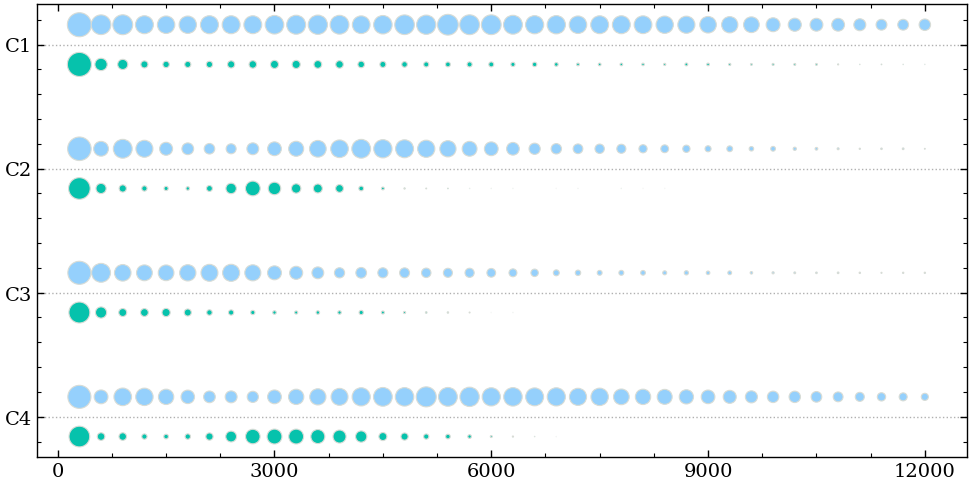

In [1587]:
fig=plt.figure(figsize=(12,6),dpi=100)
ax=plt.subplot(111)
all_ana_types=np.arange(n_clusters)
all_ana_types=list(reversed(all_ana_types))
    
xd=df_br_density_stypes.keys().to_list()
ax_xd=[d2s_bin_len*(int(x)+1) for x in xd]
al=1
yd_h=0.16
yd=[1 for x in xd]
m_max_size=300
mticker.Locator.MAXTICKS = 1000
blen_max=df_br_tilt_remote_mean_stypes.loc[all_ana_types,:].max().max()
# blen_max_type=df_brlen_mean_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).index.to_list()[0]
br_num_max=df_br_density_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).values[0]
axlegend=None
# colorlegend=None
for ai,astype in enumerate(all_ana_types):
    ydstype_mean=[m_max_size*df_br_tilt_remote_mean_stypes.loc[astype,x]/blen_max for x in xd]
    ydstype_den=[m_max_size*df_br_density_stypes.loc[astype,x]/br_num_max for x in xd]
    # yd_colors=[df_br_density_stypes.loc[astype,x] for x in xd]
    axlegend_tmp=ax.scatter(x=ax_xd,y=[y+ai+yd_h for y in yd],s=ydstype_mean,c='#95d0fc',alpha=al,marker='o',edgecolors='#d8dcd6')
    ax.scatter(x=ax_xd,y=[y+ai-yd_h for y in yd],s=ydstype_den,c='#06c2ac',alpha=al,marker='o',edgecolors='#d8dcd6')
    # if astype == blen_max_type:
    #     axlegend=axlegend_tmp
    # if astype == brden_max_type:
    #     colorlegend=axlegend_tmp
# legend1 = ax.legend(*colorlegend.legend_elements(prop='colors'), loc='upper left',title='colors',bbox_to_anchor=(1, 0, 0.5, 1))
# ax.add_artist(legend1)
# ax.legend(*axlegend.legend_elements(prop='sizes',num=4),title='',loc='upper right',bbox_to_anchor=(0.9, -0.8, 0.5, 1))
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num = 6), loc='lower left',title='sizes',bbox_to_anchor=(1, 0, 0.5, 1))
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.set_yticks(np.arange(1,1+len(all_ana_types)))
ax.set_yticklabels(['C'+str(n_clusters-c) for c in np.arange(n_clusters)])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_major_locator(MaxNLocator(5))
# ax.set_xticks(np.arange(1,1+len(all_ana_types)))
# ax.set_xticklabels(all_ana_types)
# plt.colorbar(colorlegend,ax=ax,orientation='vertical',fraction=0.012,pad=0.03)
# plt.xlim([0,10000])
plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('../figs/cluster_br_tilt_remote_'+str(int(blen_max))+'_brs_'+str(int(br_num_max))+'_at_'+d2sfea+'.png',dpi=300)

#### feature analysis of br_length

In [1173]:
def brlen_dist2soma(file_in,topath,d2s_bin_len=400,max_d2s_bins=40,
                    max_elen_bins=50,elen_bin_len=50):
    maxdist=100000
    maxelen=100000
    outdf=pd.DataFrame()
    brfea=pd.read_csv(file_in)
    maxlength=brfea['pathlength'].max()
    maxd2soma=brfea['path_dist2soma'].max()
    if maxlength and maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            sample_list=[]
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            for by in np.arange(1,max_elen_bins+1):
                minby=elen_bin_len*(by-1)
                maxby=elen_bin_len*by
                if by == (max_elen_bins +1):
                    maxby=maxelen
                sample_size=0
                if (minby < maxlength) and (minbx < maxd2soma):
                    sample_size=brfea[(brfea.length>minby) & (brfea.length<=maxby) &
                                    (brfea.dist2soma>minbx) & (brfea.dist2soma<=maxbx)].shape[0]
                sample_list.append(sample_size)
            # print(sample_list)
            outdf[bx]=sample_list
        outdf.to_csv(topath)
        return True
    return False
def brlen_mean_dist2soma(file_in,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='path_dist2soma',lenfea='pathlength'):
    maxdist=100000
    brfea=pd.read_csv(file_in)
    maxd2soma=brfea[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=brfea[(brfea[d2sfea]>minbx) & (brfea[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                sample_list.append(sdf[lenfea].mean())
            else:
                sample_list.append(0)
    return sample_list
def brlen_std_dist2soma(file_in,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='path_dist2soma',lenfea='pathlength'):
    maxdist=100000
    brfea=pd.read_csv(file_in)
    maxd2soma=brfea[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=brfea[(brfea[d2sfea]>minbx) & (brfea[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                sample_list.append(sdf[lenfea].std())
            else:
                sample_list.append(0)
    return sample_list
def brlen_density_dist2soma(file_in,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='path_dist2soma',lenfea='pathlength'):
    maxdist=100000
    brfea=pd.read_csv(file_in)
    maxd2soma=brfea[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=brfea[(brfea[d2sfea]>minbx) & (brfea[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                sample_list.append(sdf[lenfea].shape[0])
            else:
                sample_list.append(0)
    return sample_list

In [1233]:
brfea=pd.read_csv(file_in)
brfea.keys()

Index(['id', 'parent_id', 'x', 'y', 'z', 'type', 'level', 'dist2soma',
       'path_dist2soma', 'angle', 'angle_remote', 'angle_io1',
       'angle_io1_remote', 'angle_io2', 'angle_io2_remote', 'radius',
       'lcradius', 'rcradius', 'length', 'pathlength', 'contraction',
       'lclength', 'lcpathlength', 'rclength', 'rcpathlength', 'width',
       'height', 'depth', 'lslength', 'lspathlength', 'rslength',
       'rspathlength', 'lstips', 'rstips'],
      dtype='object')

In [1477]:
brfea_dir='../data/brfeas'
# d2s_bin_len=300
# max_d2s_bins=40
d2sfea='dist2soma'
# d2sfea='path_dist2soma'
# df_brlen_mean=pd.DataFrame()
# df_brlen_std=pd.DataFrame()
df_br_density=pd.DataFrame()
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        # tdata_mean=brlen_mean_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
        #                             max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        # df_brlen_mean[mfile.split('.swc')[0]]=tdata_mean
        # tdata_std=brlen_std_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
        #                             max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        # df_brlen_std[mfile.split('.swc')[0]]=tdata_std
        tdata_density=brlen_density_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
                                    max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        df_br_density[mfile.split('.swc')[0]]=tdata_density
# df_brlen_mean=df_brlen_mean.T
# df_brlen_mean.index.name='name'
# df_brlen_std=df_brlen_std.T
# df_brlen_std.index.name='name'
df_br_density=df_br_density.T
df_br_density.index.name='name'

if True:
    for swc in df_br_density.index:
        ctype='error'
        if swc in gfdf.index.to_list():
            ctype=gfdf.loc[swc,'cluster']
        # df_brlen_mean.loc[swc,'cluster']=ctype
        df_br_density.loc[swc,'cluster']=ctype
        # df_brlen_std.loc[swc,'cluster']=ctype
    # df_brlen_mean_feas=df_brlen_mean[(df_brlen_mean.cluster != 'error')].copy()
    df_br_density_feas=df_br_density[(df_br_density.cluster != 'error')].copy()
    # df_brlen_std_feas=df_brlen_std[(df_brlen_std.cluster != 'error')].copy()

# df_brlen_mean_stypes=pd.DataFrame()
# for stype in np.arange(n_clusters):
#     stdf=df_brlen_mean_feas[df_brlen_mean_feas.cluster == stype].copy()
#     stdf.drop(['cluster'],axis=1,inplace=True)
#     df_brlen_mean_stypes[stype]=stdf.mean()
# df_brlen_mean_stypes=df_brlen_mean_stypes.T
# df_brlen_mean_stypes.index.name='cluster'
# # outdf_stypes.to_csv(outstype_f)
# df_brlen_mean_stypes=pd.DataFrame()
# for stype in np.arange(n_clusters):
#     stdf=df_brlen_mean_feas[df_brlen_mean_feas.cluster == stype].copy()
#     stdf.drop(['cluster'],axis=1,inplace=True)
#     df_brlen_mean_stypes[stype]=stdf.mean()
# df_brlen_mean_stypes=df_brlen_mean_stypes.T
# df_brlen_mean_stypes.index.name='cluster'

df_br_density_stypes=pd.DataFrame()
for stype in np.arange(n_clusters):
    stdf=df_br_density_feas[df_br_density_feas.cluster == stype].copy()
    stdf.drop(['cluster'],axis=1,inplace=True)
    df_br_density_stypes[stype]=stdf.mean()
df_br_density_stypes=df_br_density_stypes.T
df_br_density_stypes.index.name='cluster'

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [1219]:
# get distance between two types
def dist_pair_types(indf,types=None,similarity=True):
    # manhattan distance
    outdf=pd.DataFrame()
    if types is None:
        types=indf.keys()
    for i1,t1 in enumerate(types):
        for i2,t2 in enumerate(types):
            if i1 > i2 :
                continue
            outdf.loc[t1,t2]=(abs(indf[t1]-indf[t2])).sum()
            outdf.loc[t2,t1]=outdf.loc[t1,t2]
    if similarity:
        outdf=1-(outdf/outdf.max().max())
    else:
        outdf=100*(outdf/outdf.max().max())
    return outdf

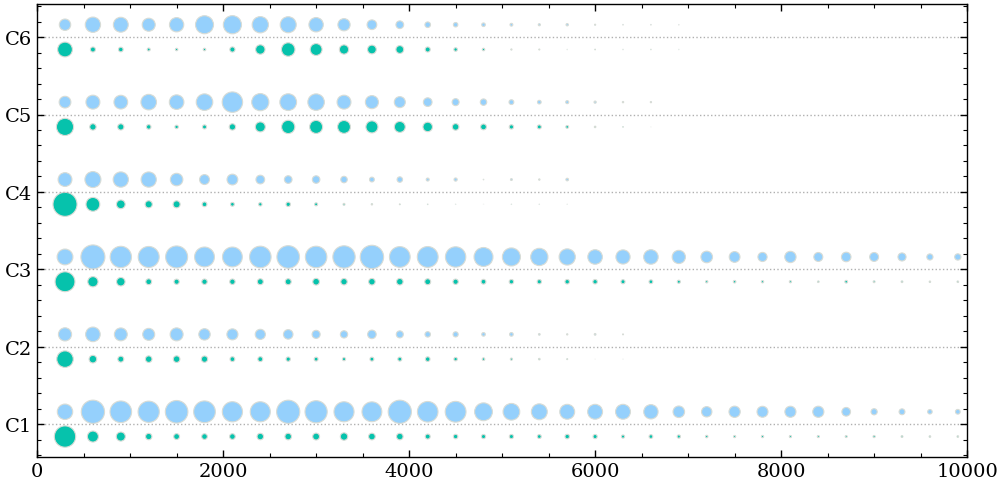

In [1245]:
fig=plt.figure(figsize=(12,6),dpi=100)
ax=plt.subplot(111)
all_ana_types=np.arange(n_clusters)
xd=df_brlen_mean_stypes.keys().to_list()
ax_xd=[d2s_bin_len*(int(x)+1) for x in xd]
al=1
yd_h=0.16
yd=[1 for x in xd]
m_max_size=300
mticker.Locator.MAXTICKS = 1000
blen_max=df_brlen_mean_stypes.loc[all_ana_types,:].max().max()
# blen_max_type=df_brlen_mean_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).index.to_list()[0]
br_num_max=df_br_density_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).values[0]
axlegend=None
# colorlegend=None
for ai,astype in enumerate(all_ana_types):
    ydstype_mean=[m_max_size*df_brlen_mean_stypes.loc[astype,x]/blen_max for x in xd]
    ydstype_den=[m_max_size*df_br_density_stypes.loc[astype,x]/br_num_max for x in xd]
    # yd_colors=[df_br_density_stypes.loc[astype,x] for x in xd]
    axlegend_tmp=ax.scatter(x=ax_xd,y=[y+ai+yd_h for y in yd],s=ydstype_mean,c='#95d0fc',alpha=al,marker='o',edgecolors='#d8dcd6')
    ax.scatter(x=ax_xd,y=[y+ai-yd_h for y in yd],s=ydstype_den,c='#06c2ac',alpha=al,marker='o',edgecolors='#d8dcd6')
    # if astype == blen_max_type:
    #     axlegend=axlegend_tmp
    # if astype == brden_max_type:
    #     colorlegend=axlegend_tmp
# legend1 = ax.legend(*colorlegend.legend_elements(prop='colors'), loc='upper left',title='colors',bbox_to_anchor=(1, 0, 0.5, 1))
# ax.add_artist(legend1)
# ax.legend(*axlegend.legend_elements(prop='sizes',num=4),title='',loc='upper right',bbox_to_anchor=(0.9, -0.8, 0.5, 1))
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num = 6), loc='lower left',title='sizes',bbox_to_anchor=(1, 0, 0.5, 1))
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.set_yticks(np.arange(1,1+len(all_ana_types)))
ax.set_yticklabels(['C'+str(c+1) for c in np.arange(n_clusters)])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_major_locator(MaxNLocator(5))
# ax.set_xticks(np.arange(1,1+len(all_ana_types)))
# ax.set_xticklabels(all_ana_types)
# plt.colorbar(colorlegend,ax=ax,orientation='vertical',fraction=0.012,pad=0.03)
plt.xlim([0,10000])
plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('../figs/cluster_br_len_'+str(int(blen_max))+'_brs_'+str(int(br_num_max))+'_at_'+d2sfea+'.png',dpi=300)

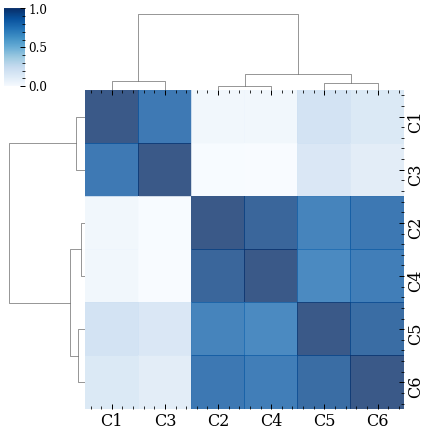

In [1253]:
def dist_pair_types(indf,types=None,similarity=True):
    # manhattan distance
    outdf=pd.DataFrame()
    if types is None:
        types=indf.keys()
    for i1,t1 in enumerate(types):
        for i2,t2 in enumerate(types):
            if i1 > i2 :
                continue
            outdf.loc['C'+str(t1+1),'C'+str(t2+1)]=(abs(indf[t1]-indf[t2])).sum()
            outdf.loc['C'+str(t2+1),'C'+str(t1+1)]=outdf.loc['C'+str(t1+1),'C'+str(t2+1)]
    if similarity:
        outdf=1-(outdf/outdf.max().max())
    else:
        outdf=100*(outdf/outdf.max().max())
    return outdf
brlen_pair_dist=dist_pair_types(df_brlen_mean_stypes.T,types=all_ana_types)
# brlen_pair_dist
clustermap=sns.clustermap(brlen_pair_dist,cmap='Blues',figsize=(6,6),alpha=0.8)
# clustermap.cax.set_xticklabels(fontsize=12)
clustermap.ax_cbar.tick_params(labelsize=12)
clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
clustermap.savefig('../figs/br_len_similarity_clustermap.png',dpi=300)

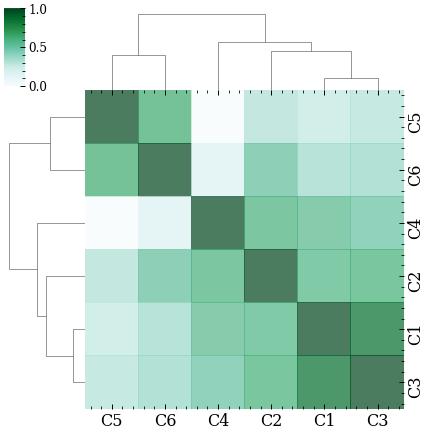

In [1254]:
brlen_pair_dist=dist_pair_types(df_br_density_stypes.T,types=all_ana_types)
# brlen_pair_dist
clustermap=sns.clustermap(brlen_pair_dist,cmap='BuGn',figsize=(6,6),alpha=0.7)
# clustermap.cax.set_xticklabels(fontsize=12)
clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
clustermap.ax_cbar.tick_params(labelsize=12)
clustermap.savefig('../figs/br_density_similarity_clustermap.png',dpi=300)

# brlen_pair_dist=dist_pair_types(df_br_density_stypes.T,types=ana_stypes,norm=100)
# clustermap=sns.clustermap(brlen_pair_dist.astype(np.int64),cmap='GnBu',figsize=(6,6),
#                         row_colors=cluster_stype_colors,
#                         col_colors=cluster_stype_colors)
# clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
# clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
# clustermap.savefig('../figs/br_density_dist_clustermap.png',dpi=300)